In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# 1. backtest.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
import pprint
try:
    import Queue as queue
except ImportError:
    import queue
import time

print("Executing backtest.py")
class Backtest(object):
    """
    Enscapsulates the settings and components for carrying out
    an event-driven backtest.
    """
#     print("*****backtest.py: 01: Class Backtest(object)*****")
    def __init__(
        self, csv_dir, symbol_list, initial_capital,
        heartbeat, start_date, data_handler, 
        execution_handler, portfolio, strategy
    ):
        """
        Initialises the backtest.
        Parameters:
        csv_dir - The hard root to the CSV data directory.
        symbol_list - The list of symbol strings.
        intial_capital - The starting capital for the portfolio.
        heartbeat - Backtest "heartbeat" in seconds
        start_date - The start datetime of the strategy.
        data_handler - (Class) Handles the market data feed.
        execution_handler - (Class) Handles the orders/fills for trades.
        portfolio - (Class) Keeps track of portfolio current and prior positions.
        strategy - (Class) Generates signals based on market data.
        """
#         print("*****backtest.py: 1. Backtest.initializing..*****")
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy

        # Added by Brad on 20191006
        # self.plots_cls = plots

        self.events = queue.Queue()
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        self.num_strats = 1
       
        self._generate_trading_instances()

    def _generate_trading_instances(self):
        # function1: call0 classes of 1)DataHandler, 2)strategy, 3)portfolion, 4)ExecutionHandler
        """
        Generates the trading instance objects from 
        their class types.
        """
#         print("*****backtest.py: 2. Backtest._generate_trading_instances*****")
#         print(
#             "backtest.py: _generate_trading_instances: Creating DataHandler, Strategy, Portfolio and ExecutionHandler"
#         )
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, 
                                            self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)
    

    def _run_backtest(self): # 
        # function1: update market bars
        # function2: identify the current event, including 1)market, 2)signal, 3)order, 4)
        """
        Executes the backtest.
        """
#         print("*****backtest.py: 3. Backtest._run_backtest*****")
#         print("Running Backtest...")
        i = 0
        while True:
            i += 1
            # print(i)

            # Update the market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.strategy.calculate_signals(event)
                            self.portfolio.update_timeindex(event)

                        elif event.type == 'SIGNAL':
                            self.signals += 1                            
                            self.portfolio.update_signal(event)

                        elif event.type == 'ORDER':
                            self.orders += 1
                            self.execution_handler.execute_order(event)

                        elif event.type == 'FILL':
                            self.fills += 1
                            self.portfolio.update_fill(event)

            time.sleep(self.heartbeat)

	# OG version
    # def _output_performance(self):
    #     """
    #     Outputs the strategy performance from the backtest.
    #     """
    #     self.portfolio.create_equity_curve_dataframe()
        
    #     print("Creating summary stats...")
    #     stats = self.portfolio.output_summary_stats()
        
    #     print("Creating equity curve...")
    #     print(self.portfolio.equity_curve.tail(10))
    #     pprint.pprint(stats)

    #     print("Signals: %s" % self.signals)
    #     print("Orders: %s" % self.orders)
    #     print("Fills: %s" % self.fills)


    def _output_performance(self):
        """
        Outputs the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
#         print("*****backtest.py: 4. Backtest._output_performance*****")
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats)

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)

    def simulate_trading(self):
        # function 1: call 1)_run _backtest, 2__output_formance
        """
        Simulates the backtest and outputs portfolio performance.
        """
#         print("*****backtest.py: 5. Backtest.simulate_trading*****")
        self._run_backtest()
        self._output_performance()

Executing backtest.py


In [3]:
# 2. event.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

print("Executing event.py")
class Event(object):
    """
    Event is base class providing an interface for all subsequent 
    (inherited) events, that will trigger further events in the 
    trading infrastructure.   
    """
#     print("*****event.py: 01 Class. Event(object)*****")
    pass


class MarketEvent(Event):
    """
    Handles the event of receiving a new market update with 
    corresponding bars.
    """
#     print("*****event.py: 02 Class. MarketEvent(Event)*****")
    def __init__(self):
        """
        Initialises the MarketEvent.
        """
#         print("*****event.py: 1. initializing..*****")
        self.type = 'MARKET'


class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    print("*****event.py: 03 Class: SignalEvent(Event)*****")
    def __init__(self, strategy_id, symbol, datetime, signal_type, strength):
        """
        Initialises the SignalEvent.
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal.
        symbol - The ticker symbol, e.g. 'GOOG'.
        datetime - The timestamp at which the signal was generated.
        signal_type - 'LONG' or 'SHORT'.
        strength - An adjustment factor "suggestion" used to scale 
            quantity at the portfolio level. Useful for pairs strategies.
        """
#         print("*****event.py: 1. SignalEvent.initializing..*****")
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength


class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system.
    The order contains a symbol (e.g. GOOG), a type (market or limit),
    quantity and a direction.
    """
    print("*****event.py: 04 Class: OrderEvent(Event)*****")
    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialises the order type, setting whether it is
        a Market order ('MKT') or Limit order ('LMT'), has
        a quantity (integral) and its direction ('BUY' or
        'SELL').
        TODO: Must handle error checking here to obtain 
        rational orders (i.e. no negative quantities etc).
        Parameters:
        symbol - The instrument to trade.
        order_type - 'MKT' or 'LMT' for Market or Limit.
        quantity - Non-negative integer for quantity.
        direction - 'BUY' or 'SELL' for long or short.
        """
#         print("*****event.py: 1. OrderEvent.initializing..*****")
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

    def print_order(self):
        """
        Outputs the values within the Order.
        """
#         print("*****event.py: 2. OrderEvent.print_order*****")
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" % 
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulates the notion of a Filled Order, as returned
    from a brokerage. Stores the quantity of an instrument
    actually filled and at what price. In addition, stores
    the commission of the trade from the brokerage.
    
    TODO: Currently does not support filling positions at
    different prices. This will be simulated by averaging
    the cost.
    """
#     print("*****event.py: 05 Class: FillEvent(Event)*****")
    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None):
        """
        Initialises the FillEvent object. Sets the symbol, exchange,
        quantity, direction, cost of fill and an optional 
        commission.
        If commission is not provided, the Fill object will
        calculate it based on the trade size and Interactive
        Brokers fees.
        Parameters:
        timeindex - The bar-resolution when the order was filled.
        symbol - The instrument which was filled.
        exchange - The exchange where the order was filled.
        quantity - The filled quantity.
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars.
        commission - An optional commission sent from IB.
        """
#         print("*****event.py: 1. FillEvent.initializing..*****")
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost

        # Calculate commission
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = commission

    def calculate_ib_commission(self):
        """
        Calculates the fees of trading based on an Interactive
        Brokers fee structure for API, in USD.
        This does not include exchange or ECN fees.
        Based on "US API Directed Orders":
        https://www.interactivebrokers.com/en/index.php?f=commission&p=stocks2
        """
#         print("*****event.py: 2. FillEvent.calculate_ib_commission*****")
#         full_cost = 1.3
#         if self.quantity <= 500:
#             full_cost = max(1.3, 0.013 * self.quantity)
#         else: # Greater than 500
#             full_cost = max(1.3, 0.008 * self.quantity)
        full_cost = commissions
        return full_cost

Executing event.py
*****event.py: 03 Class: SignalEvent(Event)*****
*****event.py: 04 Class: OrderEvent(Event)*****


In [4]:
# 3. data.py
#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

import numpy as np
import pandas as pd

# from event import MarketEvent

print("Executing data.py")
class DataHandler(object):
    """
    DataHandler is an abstract base class providing an interface for
    all subsequent (inherited) data handlers (both live and historic).
    The goal of a (derived) DataHandler object is to output a generated
    set of bars (OHLCVI) for each symbol requested. 
    This will replicate how a live strategy would function as current
    market data would be sent "down the pipe". Thus a historic and live
    system will be treated identically by the rest of the backtesting suite.
    """
#     print("*****data.py: 01 Class: Datahandler(object) ran, an abstract base class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def get_latest_bar(self, symbol):
#         print("*****data.py: 1. DataHandler.get_latest_bar*****")
        """
        Returns the last bar updated.
        """
        raise NotImplementedError("Should implement get_latest_bar()")

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
#         print("*****data.py: 2. DataHandler.get_latest_bars*****")
        """
        Returns the last N bars updated.
        """
        raise NotImplementedError("Should implement get_latest_bars()")

    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
#         print("*****data.py: 3. DataHandler.get_latest_bar_datetime*****")
        """
        Returns a Python datetime object for the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_datetime()")

    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
#         print("*****data.py: 4. DataHandler.get_latest_bar_value*****")
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        from the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_value()")

    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
#         print("*****data.py: 5. DataHandler.get_latest_bars_values*****")
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        raise NotImplementedError("Should implement get_latest_bars_values()")

    @abstractmethod
    def update_bars(self):
#         print("*****data.py: 6. DataHandler.update_bars*****")
        """
        Pushes the latest bars to the bars_queue for each symbol
        in a tuple OHLCVI format: (datetime, open, high, low, 
        close, volume, open interest).
        """
        raise NotImplementedError("Should implement update_bars()")


class HistoricCSVDataHandler(DataHandler):
    """
    HistoricCSVDataHandler is designed to read CSV files for
    each requested symbol from disk and provide an interface
    to obtain the "latest" bar in a manner identical to a live
    trading interface. 
    """
    print("*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****")
    def __init__(self, events, csv_dir, symbol_list):
        
#         print("*****data.py: 1. HistoricCSVDataHandler.initializing..")
        """
        Initialises the historic data handler by requesting
        the location of the CSV files and a list of symbols.
        It will be assumed that all files are of the form
        'symbol.csv', where symbol is a string in the list.
        Parameters:
        events - The Event Queue.
        csv_dir - Absolute directory path to the CSV files.
        symbol_list - A list of symbol strings.
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list

        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True       
        self.bar_index = 0
        self.backtest_start_date = backtest_start_date

        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        """
        Opens the CSV files from the data directory, converting
        them into pandas DataFrames within a symbol dictionary.
        For this handler it will be assumed that the data is
        taken from Yahoo. Thus its format will be respected.
        """
#         print("*****data.py: 2. HistoricCSVDataHandler._open_convert_csv_files")
        comb_index = None
        
        for s in self.symbol_list:
            # Load the CSV file with no header information, indexed on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv' % s),
                header=0, index_col=0, parse_dates=True,
                names=data_cols
            )
            
            self.symbol_data[s].reset_index(inplace = True)
            self.symbol_data[s].set_index(date_col, inplace=True)
            
            
            # Brad's revision resetting the start date of the timestamp: 
#             self.symbol_data[s] = self.symbol_data[s][self.symbol_data[date_col]>=backtest_start_date]
            self.symbol_data[s] = self.symbol_data[s][backtest_start_date:]
            
            # ).sort_values('date')
            # print("symbol_data",self.symbol_data[s])#######################
            # Combine the index to pad forward values
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)

            # Set the latest symbol_data to None
            self.latest_symbol_data[s] = []

        # Reindex the dataframes
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                reindex(index=comb_index, method='pad').iterrows()
                


    def _get_new_bar(self, symbol):
        """
        Returns the latest bar from the data feed.
        """
#         print("*****data.py: 3. HistoricCSVDataHandler._get_new_bar")
        for b in self.symbol_data[symbol]:
            yield b

    def get_latest_bar(self, symbol):
        """
        Returns the last bar from the latest_symbol list.
        """
#         print("*****data.py: 4. HistoricCSVDataHandler.get_latest_bar")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1]

    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars from the latest_symbol list,
        or N-k if less available.
        """
#         print("*****data.py: 5. HistoricCSVDataHandler.get_latest_bars")

        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-N:]

    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
#         print("*****data.py: 6. HistoricCSVDataHandler.get_latest_bar_datetime")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1][0]

    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
#         print("*****data.py: 7. HistoricCSVDataHandler.get_latest_bar_value")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return getattr(bars_list[-1][1], val_type)

    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
#         print("*****data.py: 8. HistoricCSVDataHandler.get_latest_bars_values")
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])

    def update_bars(self):
        """
        Pushes the latest bar to the latest_symbol_data structure
        for all symbols in the symbol list.
        """
#         print("*****data.py: 9. HistoricCSVDataHandler.update_bars")
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
        self.events.put(MarketEvent())

Executing data.py
*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****


In [5]:
# 4. execution.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

# from event import FillEvent, OrderEvent

print("Executing execution.py")
class ExecutionHandler(object):
    """
    The ExecutionHandler abstract class handles the interaction
    between a set of order objects generated by a Portfolio and
    the ultimate set of Fill objects that actually occur in the
    market. 
    The handlers can be used to subclass simulated brokerages
    or live brokerages, with identical interfaces. This allows
    strategies to be backtested in a very similar manner to the
    live trading engine.
    """
#     print ("*****execution.py: 01. Class: ExecutionHandler(object): abstract class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def execute_order(self, event):
#         print("*****execution.py: 1. ExecutionHandler.execute_order*****")
        """
        Takes an Order event and executes it, producing
        a Fill event that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information.
        """
        raise NotImplementedError("Should implement execute_order()")


class SimulatedExecutionHandler(ExecutionHandler):
    
    """
    The simulated execution handler simply converts all order
    objects into their equivalent fill objects automatically
    without latency, slippage or fill-ratio issues.
    This allows a straightforward "first go" test of any strategy,
    before implementation with a more sophisticated execution
    handler.
    """
#     print ("*****execution.py: 02. Class: SimulatedExecutionHandler(ExecutionHandler)*****")
    def __init__(self, events):
        """
        Initialises the handler, setting the event queues
        up internally.
        Parameters:
        events - The Queue of Event objects.
        """
#         print("*****execution.py: 1. SimulatedExecutionHandler.initializing..*****")
        self.events = events

    def execute_order(self, event):
        """
        Simply converts Order objects into Fill objects naively,
        i.e. without any latency, slippage or fill ratio problems.
        Parameters:
        event - Contains an Event object with order information.
        """
#         print("*****execution.py: 2. SimulatedExecutionHandler.execute_order*****")
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol,
                'ARCA', event.quantity, event.direction, None
            )
            self.events.put(fill_event)

Executing execution.py


In [6]:
# 5. strategy.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import SignalEvent

print("Executing strategy.py")
class Strategy(object):
#     print("*****strategy.py: 01. Class: Strategy(object): abstract class*****")
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.
    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculate_signals(self):
#         print("*****strategy.py: 1. Strategy(object).calculate_signals*****")
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")

Executing strategy.py


In [7]:
# 6. portfolio.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
from math import floor
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import FillEvent, OrderEvent
# from performance import create_sharpe_ratio, create_drawdowns


print("Executing portfolio.py")
class Portfolio(object):
    
#     print("*****portfolio.py: 01. Portfolio(object)*****")
    """
    The Portfolio class handles the positions and market
    value of all instruments at a resolution of a "bar",
    i.e. secondly, minutely, 5-min, 30-min, 60 min or EOD.
    The positions DataFrame stores a time-index of the 
    quantity of positions held. 
    The holdings DataFrame stores the cash and total market
    holdings value of each symbol for a particular 
    time-index, as well as the percentage change in 
    portfolio total across bars.
    """

    def __init__(self, bars, events, start_date, initial_capital):
#         print("*****portfolio.py: 1. Portfolio.initializing...*****")
        """
        Initialises the portfolio with bars and an event queue. 
        Also includes a starting datetime index and initial capital 
        (USD unless otherwise stated).
        Parameters:
        bars - The DataHandler object with current market data.
        events - The Event Queue object.
        start_date - The start date (bar) of the portfolio.
        initial_capital - The starting capital in USD.
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        self.current_positions = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        # Brad's add on 20191117
#         fill.direction = "None"
#         self.fill_cost = self.update_holdings_from_fill(self, fill)
        
        # =============brad's added on 20191117:===============
        self.len_symbol_list = len(self.symbol_list)
        
        
#         print("Number of assets in the portfolio： ",self.len_symbol_list)
        print("Initial Capital:",self.initial_capital, "Len Symbol:",self.len_symbol_list, 'Symbol List:', self.symbol_list)
        print("Position Value for each asset: ", self.initial_capital/self.len_symbol_list)

        
    def construct_all_positions(self):
#         print("*****portfolio.py: 2. Portfolio.construct_all_positions*****")
        """
        Constructs the positions list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]

    def construct_all_holdings(self):
#         print("*****portfolio.py: 3. Portfolio.construct_all_holdings*****")
        """
        Constructs the holdings list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return [d]

    def construct_current_holdings(self):
#         print("*****portfolio.py: 4. Portfolio.construct_current_holdings*****")
        """
        This constructs the dictionary which will hold the instantaneous
        value of the portfolio across all symbols.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return d

    def update_timeindex(self, event):
#         print("*****portfolio.py: 5. Portfolio.update_timeindex*****")
        """
        Adds a new record to the positions matrix for the current 
        market data bar. This reflects the PREVIOUS bar, i.e. all
        current market data at this stage is known (OHLCV).
        Makes use of a MarketEvent from the events queue.
        """
        ##print("symbol_list",self.symbol_list)
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])
        #######################
        
        
#         print("latest_datetime:", latest_datetime)
        # Update positions
        # ================
        dp = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime

        for s in self.symbol_list:
            dp[s] = self.current_positions[s]

        # Append the current positions
        self.all_positions.append(dp)

        # Update holdings
        # ===============
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']

        for s in self.symbol_list:
            # Approximation to the real value
            market_value = self.current_positions[s] * \
                self.bars.get_latest_bar_value(s, "Adj Close")
            dh[s] = market_value
            dh['total'] += market_value

        # Append the current holdings
        self.all_holdings.append(dh)

    # ======================
    # FILL/POSITION HANDLING
    # ======================

    def update_positions_from_fill(self, fill):
#         print("*****portfolio.py: 6. Portfolio.update_positions_from_fill*****")
        """
        Takes a Fill object and updates the position matrix to
        reflect the new position.
        Parameters:
        fill - The Fill object to update the positions with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update positions list with new quantities
        self.current_positions[fill.symbol] += fill_dir*fill.quantity

    def update_holdings_from_fill(self, fill):
#         print("*****portfolio.py: 7. Portfolio.update_holdings_from_fill*****")
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value.
        Parameters:
        fill - The Fill object to update the holdings with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update holdings list with new quantities
        fill_cost = self.bars.get_latest_bar_value(
            fill.symbol, price_col
        )
        cost = fill_dir * fill_cost * fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission)
        # Brad's add on 20191117
        return fill_cost

    def update_fill(self, event):
#         print("*****portfolio.py: 8. Portfolio.update_fill*****")
        """
        Updates the portfolio current positions and holdings 
        from a FillEvent.
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)

    def generate_naive_order(self, signal):
#         print("*****portfolio.py: 9. Portfolio.generate_naive_order*****")
        """
        Simply files an Order object as a constant quantity
        sizing of the signal object, without risk management or
        position sizing considerations.
        Parameters:
        signal - The tuple containing Signal information.
        """
        order = None

        symbol = signal.symbol
        direction = signal.signal_type
        strength = signal.strength
        # ================ Brad's change on 20191117 =================
#         mkt_quantity = qty
        symbol_value = self.bars.get_latest_bar_value(symbol, price_col)
        mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Asset: ", symbol, "symbol_value: ",symbol_value,  "mkt_quantity: ", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'

        
        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')   
    
#         if direction == 'LONG' and cur_quantity < 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'BUY')
#         if dirction == 'SHORT' and cur_quantity > 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'SELL')
    
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
#         print("*****portfolio.py: 10. Portfolio.update_signal*****")
        """
        Acts on a SignalEvent to generate new orders 
        based on the portfolio logic.
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)

    # ========================
    # POST-BACKTEST STATISTICS
    # ========================

    def create_equity_curve_dataframe(self):
#         print("*****portfolio.py: 11. Portfolio.create_equity_curve_dataframe*****")
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self.equity_curve = curve

    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown

        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]

        self.equity_curve.to_csv(ticker+"_performance"+".csv")
#         return self.equity_curve
        print(stats)


class Visualization(Portfolio):
    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown
        self.equity_curve['drawdown'].plot()

#         stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
#                  ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
#                  ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
#                  ("Drawdown Duration", "%d" % dd_duration)]

#     def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         self.stats_to_plot = super().output_summary_stats()

#     def plot_cash(self):
#         self.stats_to_plot['cash'].plot()

#     # Added by Brad on 20191007:
#     def draw_summary_plots(self):
#         print("*****portfolio.py: 13. Portfolio.draw_summary_plots*****")
#         self.equity_curve['equity_curve'].plot(figsize = (18,6))

Executing portfolio.py


In [8]:
# 7. performance.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

import numpy as np
import pandas as pd

print("Executing performance.py")
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

Executing performance.py


In [9]:
# mac.py
print("Executing mac.py")
class MovingAverageCrossStrategy(Strategy):
    print("*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****")
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        print("*****mac.py: 1. MovingAverageCrossStrategy.initializing..*****")
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_bought*****")
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold

    def calculate_signals(self, event):
        print("*****mac.py: 3. MovingAverageCrossStrategy.calculate_signals*****")
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

Executing mac.py
*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****


In [10]:
class MovingAverageConvergenceDivergence(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
#                 print(list(bars))
                if bars is not None and bars != []:
#                     print(pd.Series(bars))
                    exp1 = pd.Series(list(bars)).ewm(span=12, min_periods = 11).mean()
                    exp2 = pd.Series(list(bars)).ewm(span=26, min_periods = 25).mean()
#                     print(type(bars))
#                     print("EXP1", exp1)
#                     print("EXP2", exp2)
                    diff = pd.Series(exp1 - exp2)
#                     print("DIFF", diff)
                    dea = diff.ewm(span=9).mean()
#                     print("DEA", dea)
                    macd = 2*(pd.Series(diff-dea))
#                     print("MACD", diff)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > 0 and self.bought[symbol] == "OUT":
                        print("Date:", dt,"Long_Symbol", symbol, "bar:",bars[-1],"MACD:", macd.iloc[-1])
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < 0 and self.bought[symbol] == "LONG":
                        print("Date:", dt,"Exit_Symbol", symbol, "bar:",bars[-1],"MACD:", macd.iloc[-1])
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        print("Nooooo")
                        
                        
# def MACD(df, price_col, n_fast, n_slow, n_ema): # n_fast = 12, n_slow = 26
#     """
#     http://stockcharts.com/docs/doku.php?id=scans:indicators
#     MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
#     # Conventional look-back window for calculating MACDsign is 9
#     """
#     EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
#     EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
#     diff = pd.Series(EMAfast - EMAslow)
#     dea = diff.ewm(span = n_ema, min_periods = n_ema-1).mean()
#     macd = (pd.Series(diff - dea))*2
#     df["DIFF"] = diff
#     df["DEA"] = dea
#     df["MACD"] = macd
#     return df

In [11]:
class MACD_UPDOWN_MA(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        bars_benchmark[-1] > benchmark_ma.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [12]:
class MACD_UPDOWN_MA_NB(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        print("NB")
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [13]:
class MACD_UPDOWN_MA_SLOPE(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1
                    # MACD正在上涨，并且收盘价上穿N日均线,10日均线斜率向上,无仓位
                    if macd.iloc[-1] > macd.iloc[-2] and \
                        bars[-1] > exp0.iloc[-1] and bars[-2] < exp0.iloc[-2] and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2] and \
                        self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'
                        
                        
#                     signal = sig_dir
#                     symbol
#                     self.date_list.append(dt)
                    
            
#             print("ticker_list", self.ticker_list)
#             print("date_list", self.date_list)
#             print("signal_list", self.signal_list)

                    
    
    
#     def create_signal_files(self):
        
#         self.signal_df['Ticker'] = self.ticker_list
#         self.signal_df['Date'] = self.date_list
#         self.signal_df['Signal'] = self.signal_list
#         print(self.signal_df)
#         self.last_date = self.signal_df['Date'].values[-1]
# #             print(signal_df)
#         self.signal_df.to_csv(csv_dir+self.strategy_name+last_date+".csv")

In [14]:
class MACD_UPDOWN_MA_SLOPE_BIAS(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    ma_bias = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    bias = bars[-1]/ma_bias.iloc[-1]
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1
                    print("BIAS", bias)
                    # MACD正在上涨，并且收盘价上穿N日均线,10日均线斜率向上,无仓位
                    if macd.iloc[-1] > macd.iloc[-2] and \
                        bars[-1] > exp0.iloc[-1] and bars[-2] < exp0.iloc[-2] and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2] and \
                        self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG" or bias>1.10:
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'

In [15]:
class MACD_UPDOWN_MA_SLOPE_SHORT(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1
                    # MACD正在下跌，并且收盘价下穿N日均线,10日均线斜率向下,无仓位
                    if macd.iloc[-1] < macd.iloc[-2] and \
                        bars[-1] < exp0.iloc[-1] and bars[-2] > exp0.iloc[-2] and \
                        ma_slope.iloc[-1] < ma_slope.iloc[-2] and \
                        self.bought[symbol] == "OUT":
                        sig_dir = 'SHORT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'SHORT'


                    elif bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "SHORT":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'

In [16]:
class MACD_UPDOWN_MA_SLOPE_BIAS_BM(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    ma_bias = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    bias = bars[-1]/ma_bias.iloc[-1]
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1
                    print("BIAS", bias)
                    # MACD正在上涨，并且收盘价上穿N日均线,10日均线斜率向上,无仓位
                    if macd.iloc[-1] > macd.iloc[-2] and \
                        bars[-1] > exp0.iloc[-1] and bars[-2] < exp0.iloc[-2] and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2] and \
                        bars_benchmark[-1] > benchmark_ma.iloc[-1] and \
                        self.bought[symbol] == "OUT":
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG" or bias>1.10:
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'
                        

In [ ]:
class MA_120_UPCROSS_BIAS(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        
    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    ma_bias = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    bias = bars[-1]/ma_bias.iloc[-1]
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1
                    print("BIAS", bias)
                    # MACD正在上涨，并且收盘价上穿N日均线,10日均线斜率向上,无仓位
                    if macd.iloc[-1] > macd.iloc[-2] and \
                        bars[-1] > exp0.iloc[-1] and bars[-2] < exp0.iloc[-2] and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2] and \
                        bars_benchmark[-1] > benchmark_ma.iloc[-1] and \
                        self.bought[symbol] == "OUT":
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG" or bias>1.10:
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'

In [25]:
4/94*0.13*51000

282.1276595744681

In [17]:
class Visualization(object):
    def __init__(self, bt_csv_dir, start_date_str):
        self.equity_curve = pd.read_csv(bt_csv_dir+"equity.csv")
        self.equity_curve.drop_duplicates("datetime", inplace = True)
        self.equity_curve =self.equity_curve[self.equity_curve['datetime']>start_date_str]
        self.equity_curve.index = self.equity_curve['datetime']
        self.equity_curve = self.equity_curve[self.equity_curve['total'].map(lambda x: str(x)!="nan")]
        self.equity_curve.drop(['datetime'], axis = 1, inplace=True)
        self.plot_size = [18, 6]
        
    def plot_commissions(self):
        self.equity_curve['commission'].plot(figsize = self.plot_size)
        
    def plot_cash(self):
        self.equity_curve['cash'].plot(figsize = self.plot_size)
        
    def plot_total(self):
        self.equity_curve['total'].plot(figsize = self.plot_size)
        
    def plot_returns(self):
        self.equity_curve['returns'].plot(figsize = self.plot_size)
        
    def plot_equity_curve(self):
        self.equity_curve['equity_curve'].plot(figsize = self.plot_size)
        
    def plot_drawdown(self):
        self.equity_curve['drawdown'].plot(figsize = self.plot_size)
        
    def return_equity_df(self):
        return self.equity_curve
    

In [18]:
# Brad' revised version:

def performance(ticker, data, strat_name):
#     commissions = 5 # in USD or RMB
    # Create daily PnL
    data['daily_PL'] = data['total']-data['total'].shift(1)
    data['pct_chg'] = data['total']/data['total'].shift(1)-1
    trade = False
    profits = []
    total_profit_per_trade = 0
    single_stats = {}

    # create signals
    signal_list = []
    signal_date = []
    
    for i in range(len(data)): 
        
        
        # 1.1 open the position:
        if i > 1 and data.iloc[i-1]['market_value'] == 0 and data.iloc[i]['market_value'] != 0:
            print("-------------------")
            print("Opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 1.2 open the position (if there's no data before):
        if i == 0 and data.iloc[i]['market_value'] != 0:
            print("No data before, opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("之前无数据，开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 2. holding the position:
        if i > 1 and data.iloc[i-1]['market_value'] != 0 and data.iloc[i]['market_value'] != 0:
            print("Holding the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("持仓中")
            total_profit_per_trade += data.iloc[i]['daily_PL']
            
            
        # 3. close the position:
        if i > 1 and data.iloc[i-1]['market_value'] !=0 and data.iloc[i]['market_value'] == 0:
            print("Closed the position: ", data.iloc[i]['datetime'])
            profits.append(total_profit_per_trade)
            # The most recent trade is over, reset total_profit_per_trade
            print("This trade's pnl:", total_profit_per_trade)
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("清仓")
            total_profit_per_trade = 0
            print("-------------------")
        
            
        # 4. if the position is empty 
        if data.iloc[i]['market_value'] == 0:
            print("Position is empty: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("无仓位")

    sharpe =  np.mean(data['pct_chg'])/np.std(data['pct_chg'])*np.sqrt(252)
    win_trade = list(filter(lambda x: x >0, profits))
    loss_trade = list(filter(lambda x: x <0, profits))
    num_win_trade = len(win_trade)
    num_total_trade = len(profits)
    win_rate = num_win_trade/num_total_trade*100
    mean_win_loss_ratio = np.mean(win_trade)/(-np.mean(loss_trade))
    bt_score = (win_rate/100*mean_win_loss_ratio-(1-win_rate/100))
    total_commission = data['commission'].values[-1]
    gross_profit = sum(profits)+total_commission
    net_profit = sum(profits)
    commission_cost_rate = total_commission/gross_profit
    
    
    print('total_commission: ', total_commission)
    print('gross_profit: ', round(gross_profit,2))
    print('net_profit: ', round(net_profit,2))
    print('commission_impact: {}%'.format(abs(round(commission_cost_rate*100, 2))))
    print('win %:', round(num_win_trade/num_total_trade*100,2))
    print('PL Ratio:', round(np.mean(win_trade)/(-np.mean(loss_trade)),2))
    
#     single_stats['']
    single_stats['sharpe'] = sharpe
    single_stats['ticker'] = ticker
    single_stats['total_commission'] = total_commission
    single_stats['gross_profit'] = round(gross_profit,2)
    single_stats['net_profit'] = round(net_profit,2)
    single_stats['commission_impact'] = str(abs(round(commission_cost_rate*100, 2)))+"%"
    single_stats['win %'] = round(num_win_trade/num_total_trade*100,2)
    single_stats['PL Ratio'] = round(np.mean(win_trade)/(-np.mean(loss_trade)),2)
    single_stats['overall_score'] = round(win_rate/100*mean_win_loss_ratio-(1-win_rate/100),2)
    single_stats['strat_name'] = strat_name
    single_stats['commission'] = commissions
    single_stats['backtest_memo'] = backtest_memo
#     print(signal_list)
    return single_stats, signal_list, signal_date

In [19]:
# 导入自己的模块
from data_download_US_HK import *
from strategies import *
from positions import *

In [20]:
dow_tickers = ['CRM','V','KO','JPM','BA']

In [21]:
etf_tickers = [
#     'SCO',
#                'UCO',
#                'UVXY',
#                'NUGT',
#                'FAS',
#                'SOXL',
#                'TNA',
               'UDOW',
#                'ARKK',
#                'ARKG',
#                'PAVE',
               'UPRO',
# #                'YINN',
# #                'PBW',
               'TQQQ',
#     "AMD"
#     "TSLA"
]

len(etf_tickers)

3

In [50]:
import datetime

symbol_list = etf_tickers
ticker_performances = {}
signal_list_all = []
signal_df = []
df_list = []

if __name__ == "__main__":
    for ticker in symbol_list:
#     for ticker in ['UBT','TMF']:
#         print("starting")
        try:
                # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
            equity_folder = "./"
            csv_dir = "C:/Users/Administrator/CE_github_2/data_pipeline/Data/"

            data_cols = ['Date', 'Open', 'High','Low', 'Close', 'Adj Close' ,'Volume','Ticker'] #for ETFs
            commissions = 2 # RMB/USD per trade
            initial_capital = 100000
            # CSV 数据里
            start_date = datetime.datetime(2018,1,1,0,0,0)
            start_date_str = str(start_date)
            heartbeat = 0.0
            date_col = "Date"
            price_col = "Adj Close"
            # 日期改这边
            backtest_start_date = "2018-01-01"
#             strat_name = "MACD"
#             strat_name = "MACD_UPDOWN_MA_NB"
#             strat_name = "MACD_UPDOWN_MA_SLOPE"
            strat_name = "MACD_UPDOWN_MA_SLOPE_BIAS"
#             strat_name = "Moving_Average_Cross_Strategy"
#             strat_name = "MACD_UPDOWN_MA_SLOPE_BIAS_BM"
            backtest_memo = "US_ALL"
            benchmark_symbol = "^GSPC"
            backtest = Backtest(csv_dir, 
                                [ticker], 
                                initial_capital, 
                                heartbeat,
                                start_date,
                                HistoricCSVDataHandler, 
                                SimulatedExecutionHandler, 
                                Portfolio, 
#                                MovingAverageCrossStrategy,
#                                    MovingAverageConvergenceDivergence,
    #                             MACD_UPDOWN_MA,
#                                 MACD_UPDOWN_MA_NB,
#                                 MACD_UPDOWN_MA_SLOPE,
                                MACD_UPDOWN_MA_SLOPE_BIAS,
#                                 MACD_UPDOWN_MA_SLOPE_SHORT,
#                                 MACD_UPDOWN_MA_SLOPE_BIAS_BM
                               )

            backtest.simulate_trading()
            df_equity = pd.read_csv(ticker+"_performance"+".csv")
            df_equity.drop_duplicates("datetime", inplace = True)
    #         df_equity =df_equity[df_equity['datetime']>start_date_str]
            df_equity.index = df_equity['datetime']
            df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
            df_equity['Ticker'] = ticker
            df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
            'equity_curve', 'drawdown','Ticker']
            df_equity_copy = df_equity.copy()
            data = df_equity_copy
            df_list.append(data)
    #         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
            try:
                single_stats, signal_list, signal_date  = performance(ticker, data, strat_name)
    #         print("TICKER: ", ticker)
                ticker_performances[ticker] = single_stats
                signal_each_df = pd.DataFrame()
                signal_each_df['datetime'] = signal_date
                signal_each_df['signal'] = signal_list
                del data['datetime']
                data.reset_index(inplace=True)
                signal_each_df = signal_each_df.merge(data, on = "datetime")
                signal_each_df['Ticker'] = ticker
#                 print(data)
            except Exception as e:
                print(e)
                continue
            signal_df.append(signal_each_df)
        except Exception as e:
            print(e)

Initial Capital: 100000 Len Symbol: 1 Symbol List: ['UDOW']
Position Value for each asset:  100000.0
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS

<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:


 1.0542514761043162
BIAS 1.0780252031773785
BIAS 1.052768401563061
BIAS 1.0463035872948536
BIAS 1.0525225555607884
BIAS 1.0410615256676732
BIAS 1.038469080990212
BIAS 1.0389135884990484
BIAS 1.0520723173030884
BIAS 1.0245655486262972
BIAS 0.9785632460150349
BIAS 0.9889640546213941
BIAS 0.9889807191107078
BIAS 0.919288906530628
BIAS 0.8077875648239095
BIAS 0.8796011795072162
BIAS 0.8897239012512455
BIAS 0.8107001690547944
BIAS 0.8677523600061224
BIAS 0.9348592788464495
BIAS 0.9574020718058583
BIAS 1.0044861757683046
BIAS 1.0597146653634864
BIAS 1.0652551094148157
BIAS 1.026428610046598
BIAS 1.006803056672576
BIAS 1.026753894028404
BIAS 1.0521554796351682
Asset:  UDOW symbol_value:  97.1009521484375 mkt_quantity:  1029
BIAS 1.082174128993231
BIAS 1.034132861701494
BIAS 0.984446241767618
Asset:  UDOW symbol_value:  93.80106353759766 mkt_quantity:  1066
BIAS 0.937348188542204
BIAS 0.9378455127570937
BIAS 0.9806960928839011
BIAS 0.9832525124196747
BIAS 0.9738958533341638
BIAS 0.986562982206

BIAS 1.0632906953803825
BIAS 1.056370413360385
BIAS 1.056681105696826
BIAS 1.0371841985017103
BIAS 1.048156289149504
BIAS 1.044027375999488
BIAS 1.0284384555053923
BIAS 1.0131399538429162
Asset:  UDOW symbol_value:  96.58512878417969 mkt_quantity:  1035
BIAS 1.0015175380855552
BIAS 1.0071381328694382
BIAS 0.9841549797130562
BIAS 0.9823299683718023
BIAS 0.9708107365721743
BIAS 0.9512520877262121
BIAS 0.9559192411776538
BIAS 0.9838057608907202
BIAS 0.9795389636320647
BIAS 0.9994927854917414
BIAS 1.002861317419614
BIAS 1.0212838319552096
BIAS 1.0276704471676044
BIAS 1.025559471603102
BIAS 1.0057559371782245
BIAS 1.024868963335842
Asset:  UDOW symbol_value:  96.25624084472656 mkt_quantity:  1038
BIAS 0.9707201693826968
Asset:  UDOW symbol_value:  91.2219467163086 mkt_quantity:  1096
BIAS 0.9720313740244722
BIAS 0.9872788136055054
BIAS 0.9841117858177765
BIAS 0.9950909639538013
BIAS 1.0190756760562232
BIAS 1.05266582693741
BIAS 1.0408090754742934
BIAS 1.0403017376988408
BIAS 1.0558450887059

BIAS 0.9549576333377644
BIAS 1.116990893761808
Asset:  UDOW symbol_value:  44.864356994628906 mkt_quantity:  2228
BIAS 1.0940307367270699
BIAS 1.173939793768909
Asset:  UDOW symbol_value:  49.554359436035156 mkt_quantity:  2017
BIAS 1.201752781270252
Asset:  UDOW symbol_value:  51.4503173828125 mkt_quantity:  1943
BIAS 1.1288407641362208
Asset:  UDOW symbol_value:  49.34480285644531 mkt_quantity:  2026
BIAS 1.1853974463991195
Asset:  UDOW symbol_value:  52.84733963012695 mkt_quantity:  1892
BIAS 1.0981426014328735
BIAS 1.0687478382663318
BIAS 1.1251314021321805
Asset:  UDOW symbol_value:  54.45391082763672 mkt_quantity:  1836
BIAS 1.0158723506786178
Asset:  UDOW symbol_value:  50.5821647644043 mkt_quantity:  1976
BIAS 0.9321136641960885
BIAS 0.9765323836595297
BIAS 0.9820350101744496
BIAS 1.015914569239599
BIAS 1.0520416967798836
BIAS 1.049850751435091
BIAS 1.1020676483576908
Asset:  UDOW symbol_value:  56.74901580810547 mkt_quantity:  1762
BIAS 1.0524092684372977
BIAS 0.98148464852506

BIAS 1.035297727094477
BIAS 1.0781978269449024
BIAS 1.0856539999710986
BIAS 1.0970236540829024
BIAS 1.0983875547958613
BIAS 1.0718675031871543
BIAS 1.0721552680212396
BIAS 1.0407926005703863
BIAS 1.0044620940521256
BIAS 1.007859843068539
BIAS 0.9740797576073198
BIAS 0.9731049166075568
BIAS 0.9897164383790271
BIAS 1.0273849157701924
BIAS 1.0358310924359135
BIAS 1.0246455865664943
BIAS 1.0192462344669633
BIAS 1.0288201666814767
BIAS 1.055140026402032
BIAS 1.0400074699871378
BIAS 1.0306031788012222
BIAS 1.0274371340055553
BIAS 1.0426716495718016
BIAS 1.0325202137316312
BIAS 1.0213884135348263
BIAS 1.0218956025170418
BIAS 1.0387325240579384
BIAS 1.0436916718049005
BIAS 1.0276613888166084
BIAS 1.0007264691101532
BIAS 1.0223842544723076
BIAS 0.990780730708059
BIAS 1.0087186233219974
BIAS 1.0029266224111588
BIAS 0.999613666859351
BIAS 0.9854281173771792
BIAS 1.005104885599831
Asset:  UDOW symbol_value:  140.58000183105472 mkt_quantity:  711
BIAS 0.993066450605066
Asset:  UDOW symbol_value:  1

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
Position is empty:  2018-06-07
Position is empty:  2018-06-08
Position is empty:  2018-06-11
Position is empty:  2018-06-12
Position is empty:  2018-06-13
Position is empty:  2018-06-14
Position is empty:  2018-06-15
Position is empty:  2018-06-18
Position is empty:  2018-06-19
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
Position is empty:  2018-06-27
Position is empty:  2018-06-28
Position is empty:  2018-06-29
Position is empty:  2018-07-02
Position is empty:  2018-07-03
Position is empty:  2018-07-05
Position is empty:  2018-07-06
Position is empty:  2018-07-09
Position is empty:  2018-07-10
Position is empty:  2018-07-11
Position is empty:  2018-07-12
Position is empty:  2018-07-13
Position is empty:  2018-07-16
Position is empty:  2018-07

Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Closed the position:  2019-12-31
This trade's pnl: 4636.700271606445
-------------------
Position is empty:  2019-12-31
Position is empty:  2020-01-02
-------------------
Opened the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Closed the position:  2020-01-08
This trade's pnl: -3075.4133758544776
-------------------
Position is empty:  2020-01-08
Position is empty:  2020-01-09
Position is empty:  2020-01-10
Position is empty:  2020-01-13
Position is empty:  2020-01-14
Position is empty:  2020-01-15
Position is empty:  2020-01-16
Position is empty:  2020-01-17
Position is empty:  2020-01-21
Position is empty:  2020-01-22
Position is empty:  2

Initial Capital: 100000 Len Symbol: 1 Symbol List: ['UPRO']
Position Value for each asset:  100000.0
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS nan
BIAS 1.033502780205294


<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:


BIAS 1.051025278217013
BIAS 1.0366577882785941
BIAS 1.0397685745628307
BIAS 1.054896795182443
BIAS 1.0517423398108716
BIAS 1.0403703072775796
BIAS 1.0318878251287542
BIAS 1.055440718188704
BIAS 1.0267524752871957
BIAS 0.9902283587055203
BIAS 0.999306284082093
BIAS 0.9831725677278306
BIAS 0.9245756507002907
BIAS 0.8267221503942556
BIAS 0.8882191138526506
BIAS 0.8866829278954398
BIAS 0.8102224163641952
BIAS 0.8724605219591376
BIAS 0.9282950514354925
BIAS 0.9549842000515171
BIAS 1.0117208050481103
BIAS 1.0617034839342439
BIAS 1.0674600485062575
BIAS 1.041200680505233
BIAS 1.0247201842326599
BIAS 1.026667495938352
BIAS 1.0562800403838337
Asset:  UPRO symbol_value:  48.93635940551758 mkt_quantity:  2043
BIAS 1.0741156648931056
BIAS 1.0228480946110756
BIAS 0.9842529403213045
Asset:  UPRO symbol_value:  47.09224319458008 mkt_quantity:  2123
BIAS 0.9466049690899834
BIAS 0.9656905001382535
BIAS 0.9997643567840958
BIAS 1.0065626033100226
BIAS 1.002872443632101
BIAS 1.0127157207846176
BIAS 1.0610

Asset:  UPRO symbol_value:  44.668052673339844 mkt_quantity:  2238
BIAS 1.0333455324344312
BIAS 1.0215771362955697
BIAS 1.0463053121271622
BIAS 1.0450627833567088
BIAS 1.0456182469605662
BIAS 1.0291777158115079
BIAS 1.0387562400290073
BIAS 1.0333159053165728
BIAS 1.0209390761439177
BIAS 1.0140307682508323
BIAS 1.0036232231204167
Asset:  UPRO symbol_value:  46.71149826049805 mkt_quantity:  2140
BIAS 1.0173476244418131
BIAS 1.003382720151043
BIAS 0.9981835176727714
BIAS 0.9812382704263924
BIAS 0.9594010053070106
BIAS 0.9585243303517101
BIAS 1.0018793968862831
BIAS 1.012347233777995
BIAS 1.0304025126649294
BIAS 1.02577740751936
BIAS 1.0386771344239687
BIAS 1.045867785906796
BIAS 1.0415483394959328
BIAS 1.025059252721739
BIAS 1.047031513920823
Asset:  UPRO symbol_value:  50.19931411743164 mkt_quantity:  1992
BIAS 0.9817039776029638
Asset:  UPRO symbol_value:  47.33702850341797 mkt_quantity:  2112
BIAS 0.9778418718455726
BIAS 0.9959433997658621
BIAS 0.9828064517088183
BIAS 0.992874567077192

BIAS 1.0916172184396924
BIAS 1.1690887163879826
Asset:  UPRO symbol_value:  32.397300720214844 mkt_quantity:  3086
BIAS 1.201006444764349
Asset:  UPRO symbol_value:  33.86627197265625 mkt_quantity:  2952
BIAS 1.1396703163930288
Asset:  UPRO symbol_value:  32.876968383789055 mkt_quantity:  3041
BIAS 1.2141817920430562
Asset:  UPRO symbol_value:  35.86487197875977 mkt_quantity:  2788
BIAS 1.1136168288967634
Asset:  UPRO symbol_value:  33.55649185180664 mkt_quantity:  2980
BIAS 1.0931434877212867
BIAS 1.1410788028593841
Asset:  UPRO symbol_value:  36.82419967651367 mkt_quantity:  2715
BIAS 1.046110399234497
BIAS 0.9432275532807648
BIAS 0.9940867435439942
BIAS 0.9890399737818156
BIAS 1.02706337177049
BIAS 1.0604573018549115
BIAS 1.0439623219237075
BIAS 1.1074502368163637
Asset:  UPRO symbol_value:  38.962703704833984 mkt_quantity:  2566
BIAS 1.0649058841897308
BIAS 0.9849961758887733
BIAS 0.9944392170412595
BIAS 1.0081105622821136
BIAS 0.983492885871434
BIAS 1.0101537353511938
Asset:  UPRO

BIAS 0.9876423304513418
BIAS 0.977890348960963
BIAS 1.0204032313111304
BIAS 1.0417940051052765
BIAS 1.0651604585903907
BIAS 1.0586174165343698
BIAS 1.072149012531102
BIAS 1.0608089546710409
BIAS 1.057926566977061
BIAS 1.0011587683699488
BIAS 0.9907542227481753
BIAS 1.0046742878390855
BIAS 0.9795548462746916
BIAS 0.964899505383279
BIAS 0.9829060134836747
BIAS 1.0287746651137253
Asset:  UPRO symbol_value:  90.1500015258789 mkt_quantity:  1109
BIAS 1.0266242255103084
BIAS 1.0183581362953915
BIAS 1.0309793651130592
BIAS 1.0548873760725015
BIAS 1.0867584126666554
BIAS 1.0740810336314028
BIAS 1.0648087287476131
BIAS 1.0628383316125918
BIAS 1.0687580969592454
BIAS 1.0575583857616038
BIAS 1.0533664030379082
BIAS 1.0308214469081813
BIAS 1.049077873159176
BIAS 1.0476218936616297
BIAS 1.0253061735886881
BIAS 0.9986602790466296
Asset:  UPRO symbol_value:  101.37999725341795 mkt_quantity:  986
BIAS 1.019463552874882
BIAS 0.9893510107173515
BIAS 1.01731179522058
BIAS 1.0195937634652106
BIAS 1.015273

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-16
Position is empty:  2018-03-19
Position is empty:  2018-03-20
Position is empty:  2018-03-21
Position is empty:  2018-03-22
Position is empty:  2018-03-23
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
Position is empty:  2018-04-04
Position is empty:  2018-04-05
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
Position is empty:  2018-04-11
Position is empty:  2018-04-12
Position is empty:  2018-04-13
Position is empty:  2018-04-16
Position is empty:  2018-04-17
Position is empty:  2018-04-18
Position is empty:  2018-04-19
Position is empty:  2018-04-20
Position is empty:  2018-04-23
Position is empty:  2018-04-24
Position is empty:  2018-04-25
Position is empty:  2018-04-26
-------------------
Opened the position:  2018-04-27
Holding the position:  2018-04-30
Closed the position:  2018-05-01


Holding the position:  2019-02-21
Holding the position:  2019-02-22
Holding the position:  2019-02-25
Holding the position:  2019-02-26
Holding the position:  2019-02-27
Holding the position:  2019-02-28
Closed the position:  2019-03-01
This trade's pnl: 4569.231224060073
-------------------
Position is empty:  2019-03-01
Position is empty:  2019-03-04
Position is empty:  2019-03-05
Position is empty:  2019-03-06
Position is empty:  2019-03-07
Position is empty:  2019-03-08
Position is empty:  2019-03-11
Position is empty:  2019-03-12
Position is empty:  2019-03-13
Position is empty:  2019-03-14
Position is empty:  2019-03-15
Position is empty:  2019-03-18
Position is empty:  2019-03-19
Position is empty:  2019-03-20
Position is empty:  2019-03-21
-------------------
Opened the position:  2019-03-22
Closed the position:  2019-03-25
This trade's pnl: -5705.672943115234
-------------------
Position is empty:  2019-03-25
Position is empty:  2019-03-26
Position is empty:  2019-03-27
Positi

Position is empty:  2020-09-10
Position is empty:  2020-09-11
Position is empty:  2020-09-14
Position is empty:  2020-09-15
Position is empty:  2020-09-16
Position is empty:  2020-09-17
Position is empty:  2020-09-18
Position is empty:  2020-09-21
Position is empty:  2020-09-22
Position is empty:  2020-09-23
Position is empty:  2020-09-24
Position is empty:  2020-09-25
Position is empty:  2020-09-28
Position is empty:  2020-09-29
Position is empty:  2020-09-30
Position is empty:  2020-10-01
Position is empty:  2020-10-02
Position is empty:  2020-10-05
-------------------
Opened the position:  2020-10-06
Closed the position:  2020-10-07
This trade's pnl: -4190.543315887451
-------------------
Position is empty:  2020-10-07
-------------------
Opened the position:  2020-10-08
Holding the position:  2020-10-09
Holding the position:  2020-10-12
Closed the position:  2020-10-13
This trade's pnl: 10434.196044921846
-------------------
Position is empty:  2020-10-13
Position is empty:  2020-1

<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
<ipython-input-14-4194afb1a41b>:88: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:


BIAS 1.0458852960369285
BIAS 1.0445279862439758
BIAS 1.0652041840782303
BIAS 1.0784615775542885
BIAS 1.0458061240074892
BIAS 1.0333782457895522
BIAS 1.065259506048888
BIAS 1.0409227484752983
BIAS 1.0064647372514615
BIAS 1.0127544597660547
BIAS 0.9840866532349781
BIAS 0.927257974614677
BIAS 0.8346278963581207
BIAS 0.9114558372114326
BIAS 0.8890645817879795
BIAS 0.8000763082663699
BIAS 0.8620678862086012
BIAS 0.9314575989607974
BIAS 0.9611637247378643
BIAS 1.0332336148792387
BIAS 1.095060137248689
BIAS 1.084229780828138
BIAS 1.0768129926382917
BIAS 1.0634923828394511
BIAS 1.0557851897806785
BIAS 1.0904531974162823
Asset:  TQQQ symbol_value:  28.133472442626953 mkt_quantity:  3554
BIAS 1.1058454057684342
Asset:  TQQQ symbol_value:  29.26280212402344 mkt_quantity:  3417
BIAS 1.049174602026071
BIAS 1.0150706896488337
BIAS 0.9637417537921683
BIAS 0.9899289323150521
BIAS 1.0163902712934452
Asset:  TQQQ symbol_value:  27.88897705078125 mkt_quantity:  3585
BIAS 1.0238166419991606
BIAS 1.0243958

BIAS 1.0178045761957533
Asset:  TQQQ symbol_value:  23.47817611694336 mkt_quantity:  4259
BIAS 1.0175589732215384
BIAS 1.0064935221134041
BIAS 1.034011339832577
Asset:  TQQQ symbol_value:  24.56239891052246 mkt_quantity:  4071
BIAS 1.0269774164412913
BIAS 1.02553468421297
BIAS 1.0300385147816415
BIAS 1.0315004431084858
BIAS 1.0287620033655926
BIAS 1.0155850706164276
Asset:  TQQQ symbol_value:  24.84219741821289 mkt_quantity:  4025
BIAS 1.0296323176835354
BIAS 1.0323410767766903
BIAS 1.0264788657921726
BIAS 1.0188252704182628
BIAS 1.008914990164658
BIAS 1.0237753922845363
Asset:  TQQQ symbol_value:  26.011362075805664 mkt_quantity:  3844
BIAS 1.0198805260432335
BIAS 1.0186955845976733
BIAS 0.9991625266307677
Asset:  TQQQ symbol_value:  25.631633758544922 mkt_quantity:  3901
BIAS 0.96328484733513
BIAS 0.9609180587799109
BIAS 1.0192251134805532
Asset:  TQQQ symbol_value:  26.0913028717041 mkt_quantity:  3832
BIAS 1.032691172982758
BIAS 1.049229824323055
BIAS 1.0386762005035703
BIAS 1.0578

BIAS 1.052554218560405
BIAS 1.0383616439541068
BIAS 1.055577408863322
BIAS 1.01747537449259
BIAS 0.9595215805918901
BIAS 0.8575935894484805
BIAS 0.8047660305956641
BIAS 0.832454055219169
BIAS 0.7343056945767459
BIAS 0.773270938666378
BIAS 0.9033383810847528
BIAS 0.8493790320935775
BIAS 0.983187695384039
BIAS 0.9315442628506927
BIAS 0.9156448100302206
BIAS 0.7608668637699467
BIAS 0.8984712618508227
BIAS 0.8112410763626644
BIAS 0.6139833320944894
BIAS 0.8018621836314404
BIAS 0.5656022812166908
BIAS 0.6957471455110851
BIAS 0.6859665969085056
BIAS 0.7557451535069979
BIAS 0.7234241591773397
BIAS 0.7656098641995652
BIAS 0.9944070642428547
BIAS 1.015658551977372
BIAS 1.1679176594452472
Asset:  TQQQ symbol_value:  24.739999771118164 mkt_quantity:  4042
BIAS 1.078412301027414
BIAS 1.1586389543325868
Asset:  TQQQ symbol_value:  24.5 mkt_quantity:  4081
BIAS 1.1150902193360301
Asset:  TQQQ symbol_value:  23.81999969482422 mkt_quantity:  4198
BIAS 0.9712556677420949
BIAS 1.0193021941032485
BIAS 0.

BIAS 1.037685231225881
BIAS 1.031413452445021
BIAS 1.0250713129753675
BIAS 1.0277748141672423
BIAS 0.9841661957654426
BIAS 1.0066371401105128
BIAS 0.9665574474485965
BIAS 1.031627991815609
Asset:  TQQQ symbol_value:  91.58999633789062 mkt_quantity:  1091
BIAS 1.060936372599465
BIAS 1.0099792614589485
BIAS 1.0049280879010307
Asset:  TQQQ symbol_value:  90.54000091552734 mkt_quantity:  1104
BIAS 1.0220918303509232
Asset:  TQQQ symbol_value:  92.3000030517578 mkt_quantity:  1083
BIAS 1.0057537664516338
Asset:  TQQQ symbol_value:  90.8949966430664 mkt_quantity:  1100
BIAS 0.9837110921801149
BIAS 1.0200189564980773
Asset:  TQQQ symbol_value:  92.52999877929688 mkt_quantity:  1080
BIAS 1.0793717032579453
BIAS 1.0872046908500896
BIAS 1.0671309128668414
BIAS 1.0873191510246019
BIAS 1.0743595467945288
BIAS 0.983084517774436
Asset:  TQQQ symbol_value:  95.08000183105469 mkt_quantity:  1051
BIAS 0.9932670714752698
BIAS 0.931801456722722
BIAS 0.9916781757421731
Asset:  TQQQ symbol_value:  97.12000

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-20
Position is empty:  2018-03-21
Position is empty:  2018-03-22
Position is empty:  2018-03-23
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
Position is empty:  2018-04-04
Position is empty:  2018-04-05
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
Position is empty:  2018-04-11
Position is empty:  2018-04-12
Position is empty:  2018-04-13
Position is empty:  2018-04-16
Position is empty:  2018-04-17
Position is empty:  2018-04-18
Position is empty:  2018-04-19
Position is empty:  2018-04-20
Position is empty:  2018-04-23
Position is empty:  2018-04-24
Position is empty:  2018-04-25
Position is empty:  2018-04-26
Position is empty:  2018-04-27
Position is empty:  2018-04-30
Position is empty:  2018-05-01
Position is empty:  2018-05-02
Position is empty:  2018-05-03
Position is empty:  2018-05

Holding the position:  2020-08-25
Holding the position:  2020-08-26
Closed the position:  2020-08-27
This trade's pnl: 23385.634956359863
-------------------
Position is empty:  2020-08-27
Position is empty:  2020-08-28
Position is empty:  2020-08-31
Position is empty:  2020-09-01
Position is empty:  2020-09-02
Position is empty:  2020-09-03
Position is empty:  2020-09-04
Position is empty:  2020-09-08
Position is empty:  2020-09-09
Position is empty:  2020-09-10
Position is empty:  2020-09-11
Position is empty:  2020-09-14
Position is empty:  2020-09-15
Position is empty:  2020-09-16
Position is empty:  2020-09-17
Position is empty:  2020-09-18
Position is empty:  2020-09-21
Position is empty:  2020-09-22
-------------------
Opened the position:  2020-09-23
Closed the position:  2020-09-24
This trade's pnl: -9263.796718597412
-------------------
Position is empty:  2020-09-24
Position is empty:  2020-09-25
-------------------
Opened the position:  2020-09-28
Holding the position:  202

In [56]:
shares = 1000
price = 12.38

# value = shares*price
# print(value)

# # 1 1%

# value_1_pct = value*0.01
# print(value_1_pct)

# # 2 shares*0.05

# shares_005 = shares*0.05
# print(shares_005)

12380.0
123.8
50.0


In [64]:
# 5 dollars

In [118]:
shares_list = [1, 10, 100, 1000, 10000, 100000]
price_list = [2, 20, 200, 2000, 20000, 200000]

# shares_list = [200]
# price_list = [92]

# 6 columns
shares_data = []
price_data = []
value_data = []
value_1_pct_data = []
shares_005_data = []
commission_fees_data = []

for shares in shares_list:
    for price in price_list:
        value = shares*price
        value_1_pct = value*0.01
        shares_005 = shares*0.05
        
        shares_data.append(shares)
        price_data.append(price)
        value_data.append(value)
        value_1_pct_data.append(value_1_pct)
        shares_005_data.append(shares_005)

        print("价格为：", price)
        print("股数为：", shares)
        print("价值为($)：",value)
        print("按照1%来算，手续费为：", value_1_pct)
        print("按照shares*0.05来算，手续费为: ",shares_005)
        print("最终手续费为：-------------------")
        # 按照1%来收取
        if shares_005/value>0.01 and value_1_pct>5:
            print("最高不超过1%，手续费为：", value_1_pct)
            commission_fees_data.append(value_1_pct)
            
        if shares_005/value>0.01 and value_1_pct<=5:
            print("按照1%来收取，最低不低于5刀，手续费为：", 5)
            commission_fees_data.append(5)            
            
            
        # 按照shares*0.05来收取
        if shares_005/value<0.01 and shares_005>5:
            print("按照shares*0.05算，手续费为：",shares_005)
            commission_fees_data.append(shares_005)

        if shares_005/value<0.01 and shares_005<=5:
            print("按照shares*0.05来收取，最低不低于5刀，手续费为：",5)
            commission_fees_data.append(5)
        

#         elif value_1_pct < shares_005 and value_1_pct>5:
#             print("最高不超过1%，手续费为：", value_1_pct)
#             commission_fees_data.append(value_1_pct)
            
#         elif value_1_pct < shares_005 and value_1_pct<5:
#             print("最高不超过1%，但不能低于5刀，所以手续费为：", 5)
#             commission_fees_data.append(5)

#         elif value_1_pct < shares_005 and value_1_pct<5:
#             print("最高不超过1%，但不能低于5刀，所以手续费为：", 5)
#             commission_fees_data.append(5)
            
#         else:
#             print("其他情况")
#             commission_fees_data.append("其他情况")

价格为： 2
股数为： 1
价值为($)： 2
按照1%来算，手续费为： 0.02
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照1%来收取，最低不低于5刀，手续费为： 5
价格为： 20
股数为： 1
价值为($)： 20
按照1%来算，手续费为： 0.2
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照shares*0.05来收取，最低不低于5刀，手续费为： 5
价格为： 200
股数为： 1
价值为($)： 200
按照1%来算，手续费为： 2.0
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照shares*0.05来收取，最低不低于5刀，手续费为： 5
价格为： 2000
股数为： 1
价值为($)： 2000
按照1%来算，手续费为： 20.0
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照shares*0.05来收取，最低不低于5刀，手续费为： 5
价格为： 20000
股数为： 1
价值为($)： 20000
按照1%来算，手续费为： 200.0
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照shares*0.05来收取，最低不低于5刀，手续费为： 5
价格为： 200000
股数为： 1
价值为($)： 200000
按照1%来算，手续费为： 2000.0
按照shares*0.05来算，手续费为:  0.05
最终手续费为：-------------------
按照shares*0.05来收取，最低不低于5刀，手续费为： 5
价格为： 2
股数为： 10
价值为($)： 20
按照1%来算，手续费为： 0.2
按照shares*0.05来算，手续费为:  0.5
最终手续费为：-------------------
按照1%来收取，最低不低于5刀，手续费为： 5
价格为： 20
股数为： 10
价值为($)： 200
按照1%来算，手续费为： 2.0
按照shares*0.05来算，手续费为:  0.5
最终手续费

In [119]:
df_commissions = pd.DataFrame()
df_commissions['shares'] = shares_data
df_commissions['price'] = price_data
df_commissions['value'] = value_data
df_commissions['value_1pct'] = value_1_pct_data
df_commissions['shares_005'] = shares_005_data
df_commissions['minimum_commissions'] = 5
df_commissions['commission_fees'] = commission_fees_data
df_commissions

,shares,price,value,value_1pct,shares_005,minimum_commissions,commission_fees
0,1,2,2,2.000000e-02,0.05,5,5.0
1,1,20,20,2.000000e-01,0.05,5,5.0
2,1,200,200,2.000000e+00,0.05,5,5.0
3,1,2000,2000,2.000000e+01,0.05,5,5.0
4,1,20000,20000,2.000000e+02,0.05,5,5.0
5,1,200000,200000,2.000000e+03,0.05,5,5.0
6,10,2,20,2.000000e-01,0.50,5,5.0
7,10,20,200,2.000000e+00,0.50,5,5.0
8,10,200,2000,2.000000e+01,0.50,5,5.0
9,10,2000,20000,2.000000e+02,0.50,5,5.0


In [52]:
df_list_data = pd.concat(df_list)
df_list_data.set_index("datetime", inplace = True)
signal_df_all = pd.concat(signal_df)

signal_df_all.dropna(inplace = True)
signal_df_all.set_index('datetime', inplace = True)

Text(0.5, 1.0, 'MACD Slope')

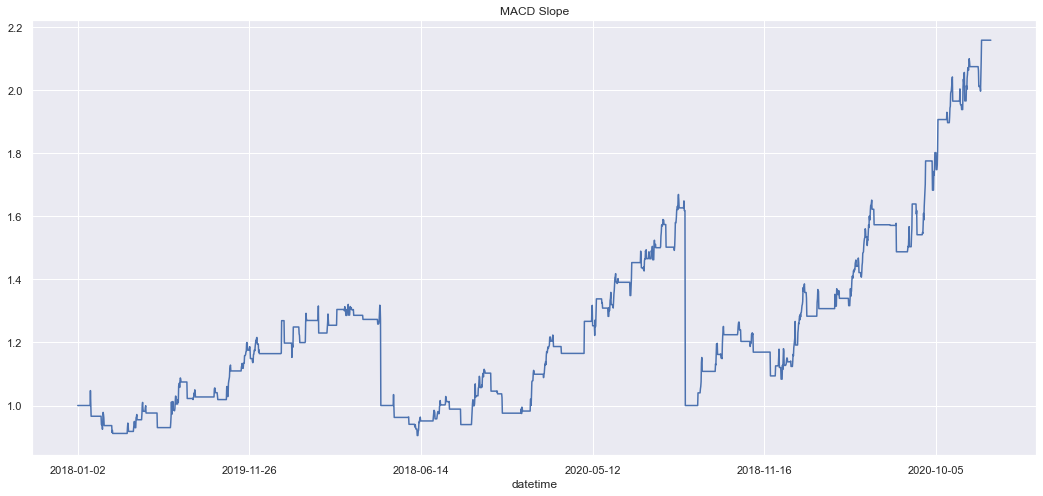

In [53]:
# TQQQ
signal_df_all['equity_curve'].plot(figsize = (18,8));
plt.title("MACD Slope")

In [50]:
signal_df_all.tail(30)

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL,pct_chg
datetime,,,,,,,,,,,
2021-03-18,无仓位,0.000000,207377.850988,176,207377.850988,0.000000,2.073779,0.025128,TQQQ,0.000000,0.000000
2021-03-19,无仓位,0.000000,207377.850988,176,207377.850988,0.000000,2.073779,0.025128,TQQQ,0.000000,0.000000
2021-03-22,无仓位,0.000000,207377.850988,176,207377.850988,0.000000,2.073779,0.025128,TQQQ,0.000000,0.000000
2021-03-23,开仓,98620.301674,107450.125006,178,206070.426680,-0.006305,2.060704,0.038202,TQQQ,-1307.424309,-0.006305
2021-03-24,持仓中,93639.920670,107450.125006,178,201090.045675,-0.024168,2.010900,0.088006,TQQQ,-4980.381004,-0.024168
2021-03-25,清仓,0.000000,201088.045675,180,201088.045675,-0.000010,2.010880,0.088026,TQQQ,-2.000000,-0.000010
2021-03-25,无仓位,0.000000,201088.045675,180,201088.045675,-0.000010,2.010880,0.088026,TQQQ,-2.000000,-0.000010
2021-03-26,无仓位,0.000000,201088.045675,180,201088.045675,0.000000,2.010880,0.088026,TQQQ,0.000000,0.000000
2021-03-29,开仓,99940.798279,101088.843954,182,201029.642233,-0.000290,2.010296,0.088610,TQQQ,-58.403442,-0.000290


In [51]:
13583.25/13134.575

1.0341598414870674

Text(0.5, 1.0, 'MACD Slope BIAS')

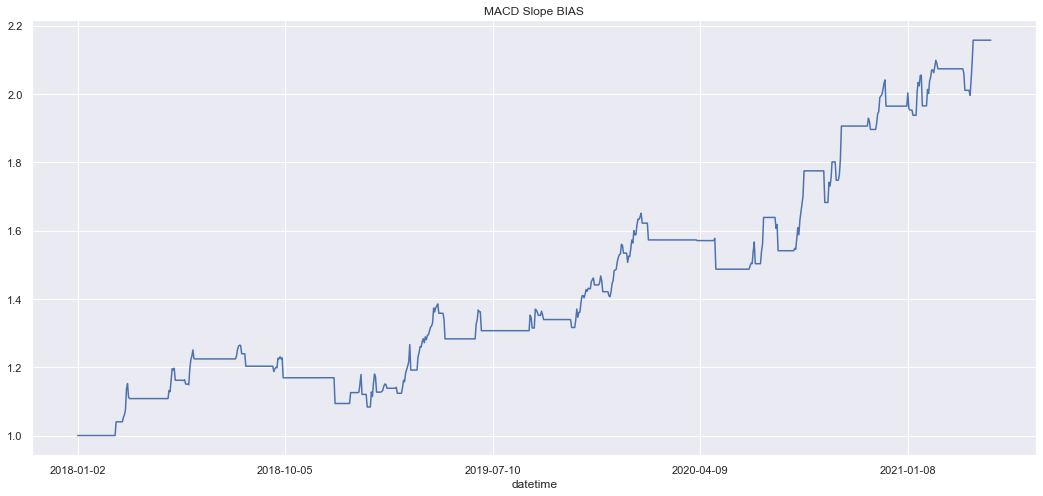

In [46]:
# TQQQ
signal_df_all['equity_curve'].plot(figsize = (18,8));
plt.title("MACD Slope BIAS")

Text(0.5, 1.0, 'MACD Strategy')

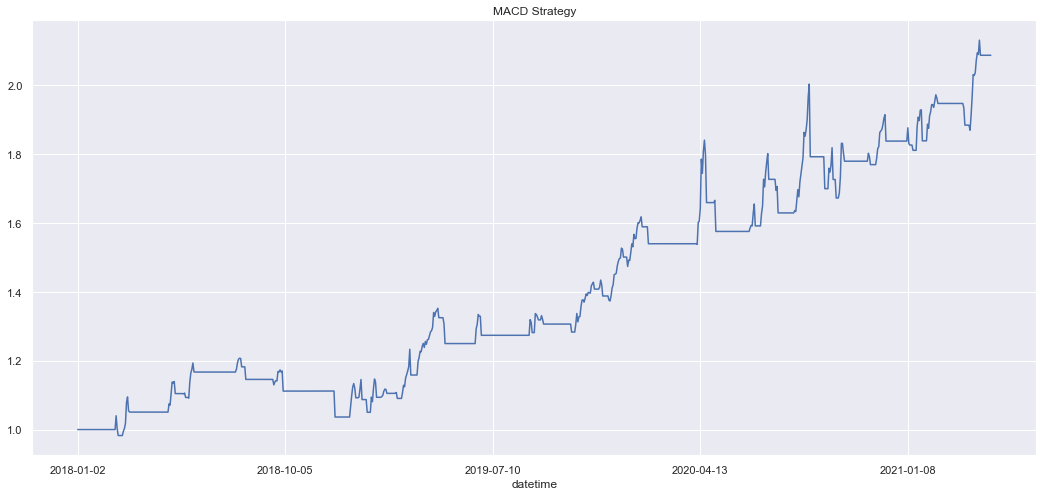

In [41]:
# TQQQ
signal_df_all['equity_curve'].plot(figsize = (18,8));
plt.title("MACD Strategy")

<AxesSubplot:xlabel='datetime'>

<AxesSubplot:xlabel='datetime'>

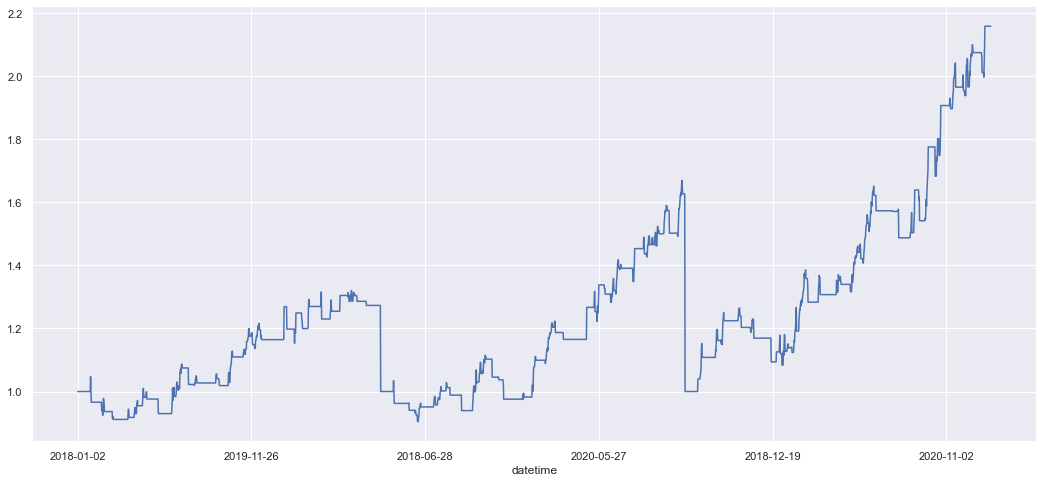

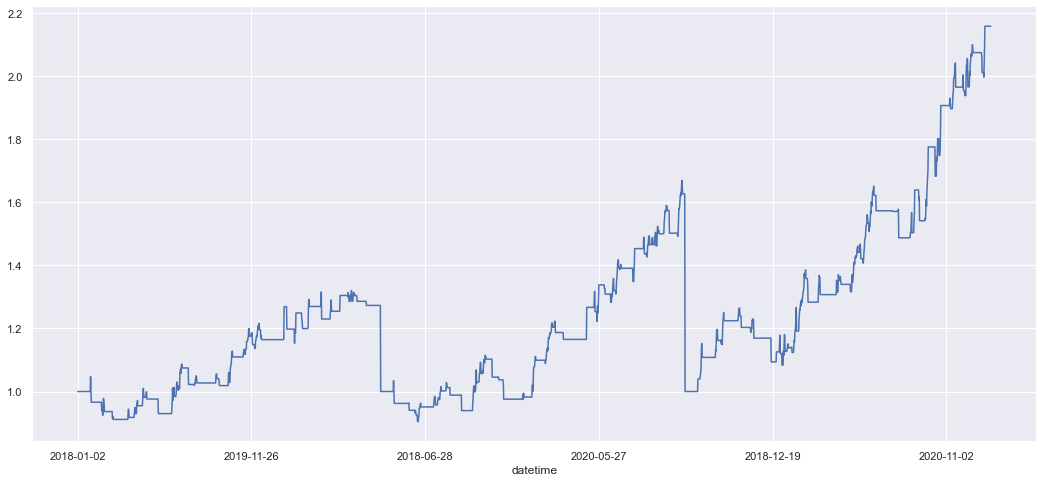

In [24]:
signal_df_all['equity_curve'].plot(figsize = (18,8))

In [24]:
signal_df_all

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,,
2018-01-02,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-03,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-04,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-05,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-08,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-04-21,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000
2021-04-22,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000
2021-04-23,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000


In [42]:
signal_df_all.tail(20)

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,,
2021-03-31,无仓位,0.000000,221085.368448,340,221085.368448,-0.000009,2.210854,0.227314,TQQQ,-2.000000
2021-04-01,开仓,105010.501671,121153.666109,342,226164.167780,0.022972,2.261642,0.176526,TQQQ,5078.799332
2021-04-05,持仓中,111317.704010,121153.666109,342,232471.370119,0.027888,2.324714,0.113454,TQQQ,6307.202339
2021-04-06,持仓中,111054.897995,121153.666109,342,232208.564104,-0.001130,2.322086,0.116082,TQQQ,-262.806015
2021-04-07,持仓中,111876.147995,121153.666109,342,233029.814104,0.003537,2.330298,0.107870,TQQQ,821.250000
2021-04-08,持仓中,115369.200668,121153.666109,342,236522.866777,0.014990,2.365229,0.072939,TQQQ,3493.052673
2021-04-09,持仓中,117460.646324,121153.666109,342,238614.312433,0.008842,2.386143,0.052025,TQQQ,2091.445656
2021-04-12,持仓中,117000.748329,121153.666109,342,238154.414438,-0.001927,2.381544,0.056624,TQQQ,-459.897995
2021-04-13,持仓中,121008.452339,121153.666109,342,242162.118448,0.016828,2.421621,0.016547,TQQQ,4007.704010


In [45]:
signal_df_all[signal_df_all['Ticker']=="UDOW"]

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,,
2018-01-02,无仓位,0.000000,100000.000000,0,100000.00000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-03,无仓位,0.000000,100000.000000,0,100000.00000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-04,无仓位,0.000000,100000.000000,0,100000.00000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-05,无仓位,0.000000,100000.000000,0,100000.00000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-08,无仓位,0.000000,100000.000000,0,100000.00000,0.000000,1.000000,0.000000,UDOW,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-04-22,开仓,97117.358276,165131.419483,290,262248.77776,-0.010740,2.622488,0.065274,UDOW,-2847.179138
2021-04-23,清仓,0.000000,262246.777760,292,262246.77776,-0.000008,2.622468,0.065294,UDOW,-2.000000
2021-04-23,无仓位,0.000000,262246.777760,292,262246.77776,-0.000008,2.622468,0.065294,UDOW,-2.000000


In [46]:
signal_df_all

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,,
2018-01-02,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-03,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-04,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-05,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
2018-01-08,无仓位,0.00000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,UDOW,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-04-21,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000
2021-04-22,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000
2021-04-23,无仓位,0.00000,240243.868448,344,240243.868448,0.000000,2.402439,0.035729,TQQQ,0.000000


In [37]:
signal_df_all

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL,pct_chg
datetime,,,,,,,,,,,
2018-01-02,无仓位,0.0,100000.000000,0,100000.000000,0.0,1.000000,0.000000,CRM,0.0,0.0
2018-01-03,无仓位,0.0,100000.000000,0,100000.000000,0.0,1.000000,0.000000,CRM,0.0,0.0
2018-01-04,无仓位,0.0,100000.000000,0,100000.000000,0.0,1.000000,0.000000,CRM,0.0,0.0
2018-01-05,无仓位,0.0,100000.000000,0,100000.000000,0.0,1.000000,0.000000,CRM,0.0,0.0
2018-01-08,无仓位,0.0,100000.000000,0,100000.000000,0.0,1.000000,0.000000,CRM,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-05,无仓位,0.0,97267.468643,120,97267.468643,0.0,0.972675,0.144242,BA,0.0,0.0
2021-05-06,无仓位,0.0,97267.468643,120,97267.468643,0.0,0.972675,0.144242,BA,0.0,0.0
2021-05-07,无仓位,0.0,97267.468643,120,97267.468643,0.0,0.972675,0.144242,BA,0.0,0.0


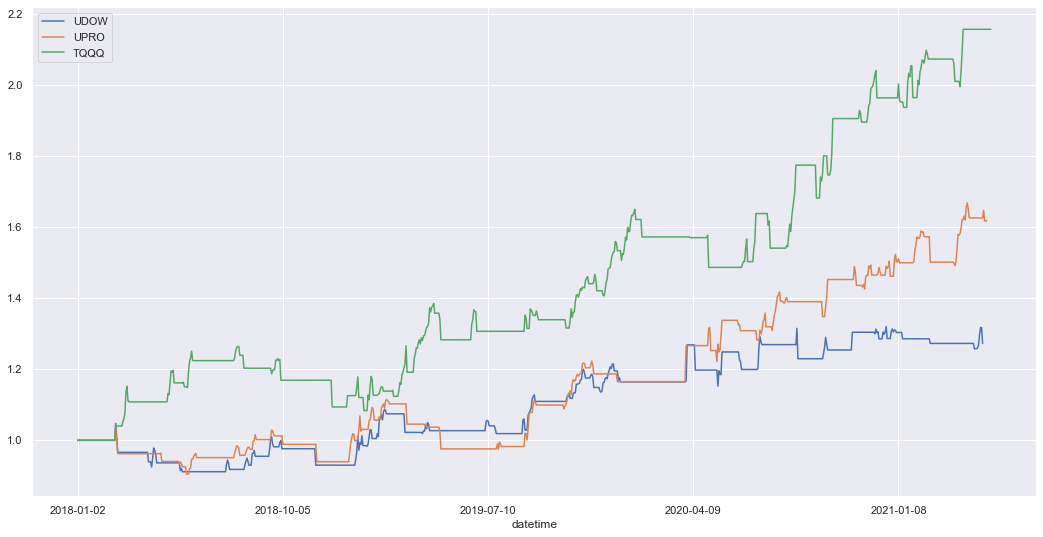

In [54]:
for ticker in etf_tickers:
    signal_df_all[signal_df_all['Ticker']==ticker]['equity_curve'].plot(figsize = (18,9))
    plt.legend(etf_tickers)

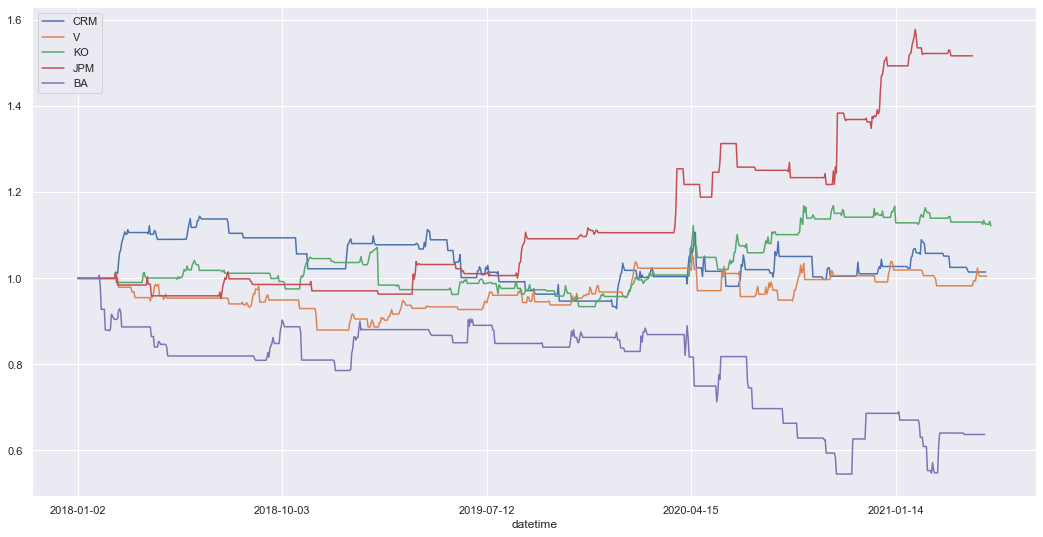

In [43]:
# MACD SLOPE BIAS without BM Filter
for ticker in dow_tickers:
    signal_df_all[signal_df_all['Ticker']==ticker]['equity_curve'].plot(figsize = (18,9))
    plt.legend(dow_tickers)

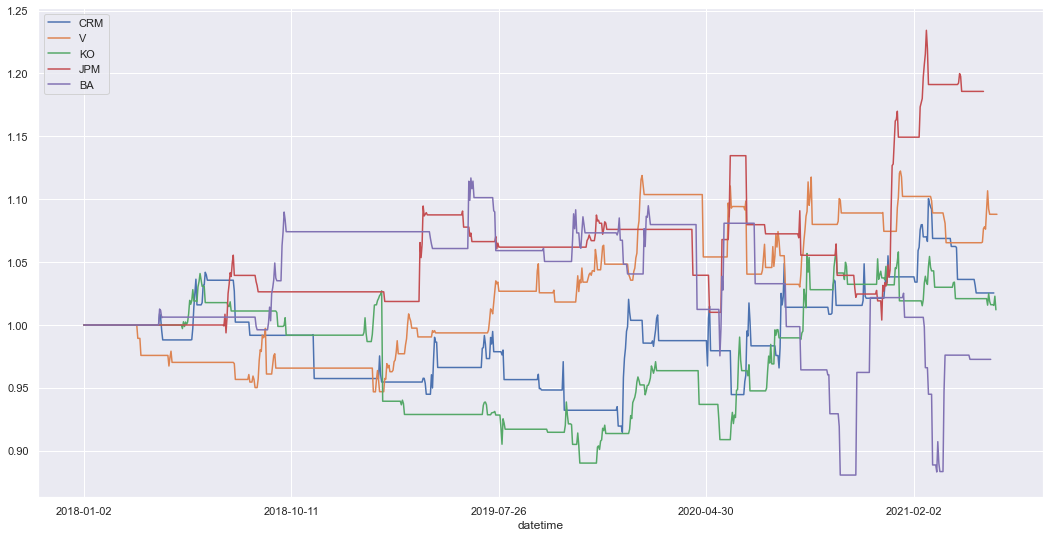

In [35]:
# MACD SLOPE BIAS with BM Filter
for ticker in dow_tickers:
    signal_df_all[signal_df_all['Ticker']==ticker]['equity_curve'].plot(figsize = (18,9))
    plt.legend(dow_tickers)

In [55]:
signal_df_all[signal_df_all.index =="2021-04-20" ].tail(20)

,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL,pct_chg
datetime,,,,,,,,,,,
2021-04-20,无仓位,0.000000,127284.484680,148,127284.484680,0.000000,1.272845,0.047625,UDOW,0.000000,0.000000
2021-04-20,持仓中,112430.416954,50194.710560,162,162625.127514,-0.015178,1.626251,0.042586,UPRO,-2506.342369,-0.015178
2021-04-20,无仓位,0.000000,215759.328085,184,215759.328085,0.000000,2.157593,0.000020,TQQQ,0.000000,0.000000


In [56]:
signal_df_all_ = signal_df_all[signal_df_all['signal']!="清仓"]

<AxesSubplot:xlabel='datetime'>

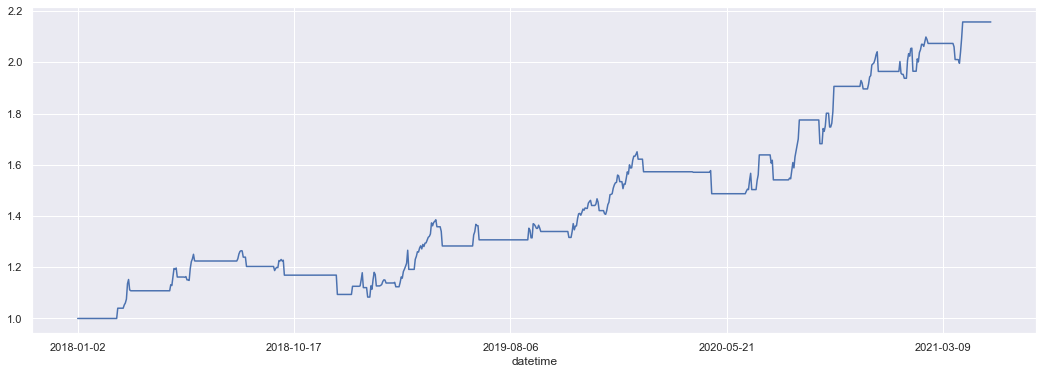

In [57]:
signal_df_all_[signal_df_all_['Ticker']=="TQQQ"]['equity_curve'].plot(figsize = (18,6))

<AxesSubplot:xlabel='datetime'>

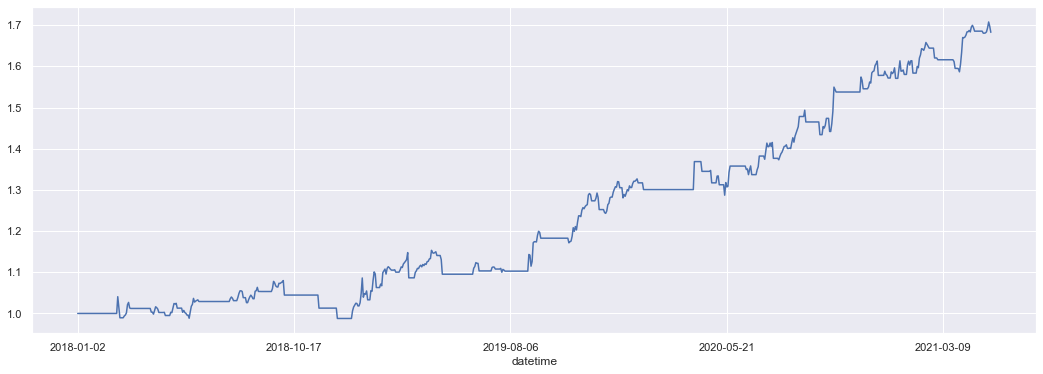

In [58]:
((signal_df_all_.groupby(signal_df_all_.index)['equity_curve'].sum())/3).plot(figsize = (18,6))

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
 
# Create random data with numpy
import numpy as np

In [ ]:

 
N = 500
random_x = np.linspace(0, 1, N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = random_x,
    y = random_y
)

data = [trace]
 
py.iplot(data, filename='basic-line')
# ————————————————
# 版权声明：本文为CSDN博主「王大鱼」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/cyan_soul/article/details/95008854

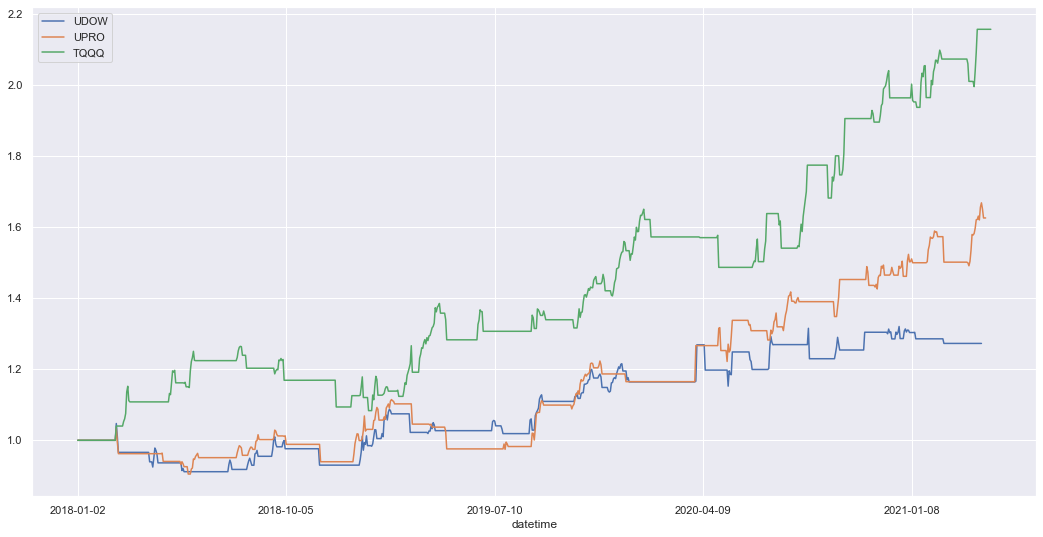

In [194]:
# MACD slope short
for ticker in etf_tickers:
    signal_df_all[signal_df_all['Ticker']==ticker]['equity_curve'].plot(figsize = (18,9))
    plt.legend(etf_tickers)

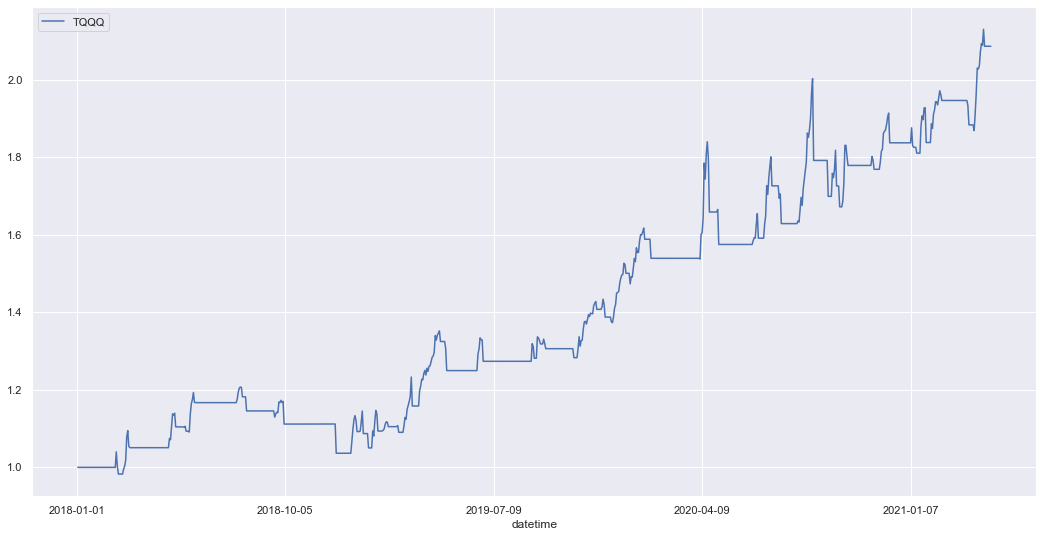

In [42]:
# MACD
for ticker in etf_tickers:
    signal_df_all[signal_df_all['Ticker']==ticker]['equity_curve'].plot(figsize = (18,9))
    plt.legend(etf_tickers)

<AxesSubplot:xlabel='datetime'>

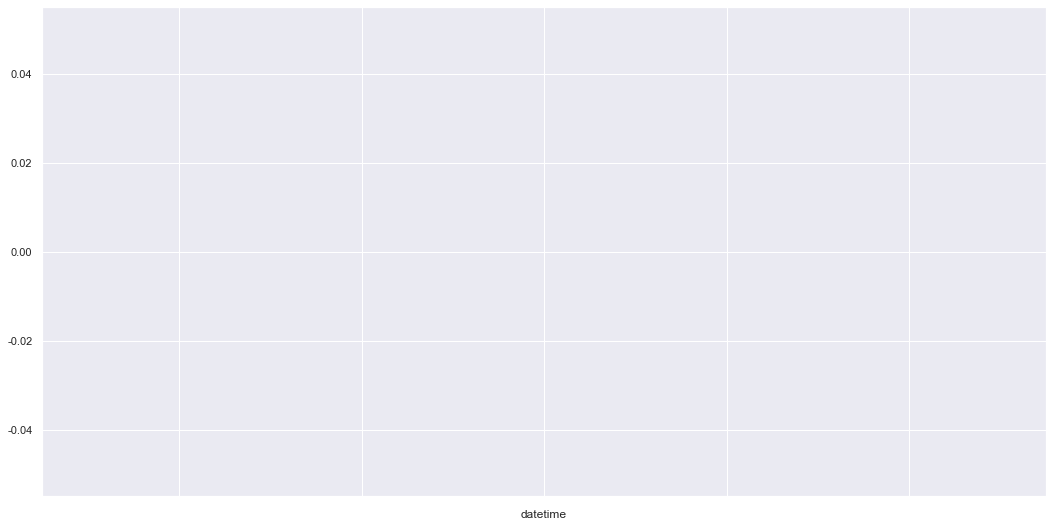

In [43]:
# Moving_Average_Cross_Strategy
signal_df_all[signal_df_all['Ticker']=="PBW"]['equity_curve'].plot(figsize = (18,9))

In [31]:
signal_df_all[signal_df_all['Ticker']=='UPRO'].tail(20)

,datetime,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
873,2021-03-10,开仓,1.018231e+06,1.490326e+06,286,2.508557e+06,7.337479e-03,2.508557,0.092223,UPRO,18272.409119
874,2021-03-11,持仓中,1.049644e+06,1.490326e+06,286,2.539969e+06,1.252227e-02,2.539969,0.060810,UPRO,31412.815399
875,2021-03-12,持仓中,1.053944e+06,1.490326e+06,286,2.544269e+06,1.692866e-03,2.544269,0.056510,UPRO,4299.828796
876,2021-03-15,持仓中,1.072935e+06,1.490326e+06,286,2.563260e+06,7.464292e-03,2.563260,0.037519,UPRO,18991.168793
877,2021-03-16,持仓中,1.069113e+06,1.490326e+06,286,2.559438e+06,-1.491137e-03,2.559438,0.041341,UPRO,-3822.171326
878,2021-03-17,持仓中,1.078907e+06,1.490326e+06,286,2.569232e+06,3.826686e-03,2.569232,0.031547,UPRO,9794.165894
879,2021-03-18,持仓中,1.031967e+06,1.490326e+06,286,2.522292e+06,-1.827010e-02,2.522292,0.078487,UPRO,-46940.147125
880,2021-03-19,清仓,0.000000e+00,2.522290e+06,288,2.522290e+06,-7.929295e-07,2.522290,0.078489,UPRO,-2.000000
881,2021-03-19,无仓位,0.000000e+00,2.522290e+06,288,2.522290e+06,-7.929295e-07,2.522290,0.078489,UPRO,-2.000000
882,2021-03-22,无仓位,0.000000e+00,2.522290e+06,288,2.522290e+06,0.000000e+00,2.522290,0.078489,UPRO,0.000000


In [49]:
perf_df = pd.DataFrame(ticker_performances).T
perf_df.sort_values("overall_score", ascending=False, inplace = True)
perf_df.reset_index(inplace = True)

In [50]:
# Moving_Average_Cross_Strategy
perf_df

,index,total_commission,gross_profit,net_profit,commission_impact,win %,PL Ratio,overall_score,strat_name,commission,backtest_memo
0,PBW,60,1.79006e+06,1.79e+06,0.0%,46.67,8.83,3.59,Moving_Average_Cross_Strategy,2,US_ALL
1,ARKK,60,1.38439e+06,1.38433e+06,0.0%,46.67,4.88,1.75,Moving_Average_Cross_Strategy,2,US_ALL
2,ARKG,72,1.06485e+06,1.06478e+06,0.01%,61.11,2.47,1.12,Moving_Average_Cross_Strategy,2,US_ALL
3,UCO,52,1.09109e+06,1.09104e+06,0.0%,53.85,2.58,0.93,Moving_Average_Cross_Strategy,2,US_ALL
4,TNA,68,1.04464e+06,1.04457e+06,0.01%,41.18,2.95,0.63,Moving_Average_Cross_Strategy,2,US_ALL
5,TQQQ,58,1.27202e+06,1.27196e+06,0.0%,57.14,1.82,0.61,Moving_Average_Cross_Strategy,2,US_ALL
6,SOXL,62,1.3865e+06,1.38644e+06,0.0%,46.67,2.31,0.55,Moving_Average_Cross_Strategy,2,US_ALL
7,PAVE,74,196672,196598,0.04%,55.56,1.29,0.27,Moving_Average_Cross_Strategy,2,US_ALL
8,NUGT,66,426412,426346,0.02%,43.75,1.77,0.21,Moving_Average_Cross_Strategy,2,US_ALL
9,SCO,46,263980,263934,0.02%,36.36,2.1,0.13,Moving_Average_Cross_Strategy,2,US_ALL


In [43]:
# MACD slope （表现弱于MACD）
perf_df

,index,total_commission,gross_profit,net_profit,commission_impact,win %,PL Ratio,overall_score,strat_name,commission,backtest_memo
0,UVXY,208,5.13006e+06,5.12985e+06,0.0%,26.92,7.04,1.16,MACD_UPDOWN_MA_SLOPE,2,US_ALL
1,PBW,258,976668,976410,0.03%,53.12,2.23,0.72,MACD_UPDOWN_MA_SLOPE,2,US_ALL
2,ARKK,250,928107,927857,0.03%,48.39,2.2,0.55,MACD_UPDOWN_MA_SLOPE,2,US_ALL
3,ARKG,270,660726,660456,0.04%,46.27,1.97,0.37,MACD_UPDOWN_MA_SLOPE,2,US_ALL
4,TNA,244,907336,907092,0.03%,50.82,1.62,0.33,MACD_UPDOWN_MA_SLOPE,2,US_ALL
5,TQQQ,278,961450,961172,0.03%,55.07,1.38,0.31,MACD_UPDOWN_MA_SLOPE,2,US_ALL
6,FAS,272,669118,668846,0.04%,48.53,1.62,0.27,MACD_UPDOWN_MA_SLOPE,2,US_ALL
7,PAVE,286,269659,269373,0.11%,39.44,2.19,0.26,MACD_UPDOWN_MA_SLOPE,2,US_ALL
8,UPRO,274,473077,472803,0.06%,52.94,1.31,0.22,MACD_UPDOWN_MA_SLOPE,2,US_ALL
9,YINN,232,593902,593670,0.04%,50,1.38,0.19,MACD_UPDOWN_MA_SLOPE,2,US_ALL


In [32]:
# 纯MACD策略,优于
perf_df

,index,total_commission,gross_profit,net_profit,commission_impact,win %,PL Ratio,overall_score,strat_name,commission,backtest_memo
0,PBW,318,1.51359e+06,1.51327e+06,0.02%,43.04,3.86,1.09,MACD,2,US_ALL
1,ARKK,310,1.32445e+06,1.32414e+06,0.02%,48.05,2.99,0.92,MACD,2,US_ALL
2,ARKG,338,1.34182e+06,1.34148e+06,0.03%,41.67,3.61,0.92,MACD,2,US_ALL
3,UPRO,294,1.50004e+06,1.49974e+06,0.02%,50.68,2.45,0.75,MACD,2,US_ALL
4,FAS,314,1.82485e+06,1.82454e+06,0.02%,51.28,2.37,0.73,MACD,2,US_ALL
5,UDOW,286,1.58527e+06,1.58498e+06,0.02%,57.75,1.96,0.71,MACD,2,US_ALL
6,PAVE,314,699617,699303,0.04%,42.31,3.03,0.71,MACD,2,US_ALL
7,UVXY,340,3.20668e+06,3.20634e+06,0.01%,21.18,6.74,0.64,MACD,2,US_ALL
8,TNA,310,1.48461e+06,1.4843e+06,0.02%,40.26,2.6,0.45,MACD,2,US_ALL
9,TQQQ,342,1.21436e+06,1.21402e+06,0.03%,47.06,1.92,0.37,MACD,2,US_ALL


In [44]:
to_csv_folder = "C:/Users/Administrator/CE_github_2/data_pipeline/Performance/"
perf_df.to_csv(to_csv_folder+"Leveraged_ETF_MACD_slope_W_COMM.csv")

In [53]:
df_equity_copy

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
0,2018-01-01,0.0,1.500000e+06,0,1.500000e+06,NaN,NaN,NaN,161005,NaN
1,2019-01-02,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
2,2019-01-03,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
3,2019-01-04,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
4,2019-01-07,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
...,...,...,...,...,...,...,...,...,...,...
528,2021-03-05,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
529,2021-03-08,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
530,2021-03-09,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
531,2021-03-10,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0


In [60]:
df_list_data[df_list_data['Ticker']=="001508"]

,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,
2018-01-01,0.0,1500000.000,0,1500000.000,NaN,NaN,NaN,001508,NaN
2019-01-02,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-03,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-04,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-07,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
...,...,...,...,...,...,...,...,...,...
2021-03-05,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-08,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-09,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0


# 可视化验证信号

In [32]:
def MACD(df, price_col, n_fast, n_slow, n_ema): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    diff = pd.Series(EMAfast - EMAslow)
    dea = diff.ewm(span = n_ema, min_periods = n_ema-1).mean()
    macd = (pd.Series(diff - dea))*2
    df["DIFF"] = diff
    df["DEA"] = dea
    df["MACD"] = macd
    return df

In [33]:
data = LOAD_DATA.read_data_from_yf_D(['UDOW'])

Loading from YahooFinance: No.1 / 1: UDOW
[*********************100%***********************]  1 of 1 completed
All Data Loaded


In [244]:
# data = LOAD_DATA.read_data_from_Sina(['001679'],"2020-03-31","2021-03-31")

Loading from SinaFinance: No.1 / 1: 001679
All Data Loaded


In [34]:
data

[          Date        Open        High         Low       Close   Adj Close  \
 0   2020-04-28   56.040001   56.119999   52.910000   53.450001   53.336296   
 1   2020-04-29   56.320000   57.779999   55.700001   56.869999   56.749016   
 2   2020-04-30   55.360001   56.070000   53.830002   54.799999   54.683426   
 3   2020-05-01   52.220001   52.770000   50.189999   50.730000   50.622078   
 4   2020-05-04   49.349998   51.000000   48.369999   50.820000   50.711887   
 ..         ...         ...         ...         ...         ...         ...   
 247 2021-04-21  137.119995  141.820007  137.020004  141.589996  141.589996   
 248 2021-04-22  141.360001  141.449997  136.350006  137.559998  137.559998   
 249 2021-04-23  137.210007  141.839996  136.460007  140.339996  140.339996   
 250 2021-04-26  141.330002  141.729996  139.199997  139.820007  139.820007   
 251 2021-04-27  139.479996  140.410004  138.309998  139.720001  139.720001   
 
       Volume Ticker  
 0    7872600   UDOW  
 1  

In [35]:
df = pd.concat(data)
df_macd = MACD(df, price_col, 12, 26, 9)

df_macd['MA5'] = pd.Series(df_macd[price_col]).rolling(window=5).mean()
df_macd['MA10'] = pd.Series(df_macd[price_col]).rolling(window=10).mean()

In [36]:
df_macd

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,DIFF,DEA,MACD,MA5,MA10
0,2020-04-28,56.040001,56.119999,52.910000,53.450001,53.336296,7872600,UDOW,NaN,NaN,NaN,NaN,NaN
1,2020-04-29,56.320000,57.779999,55.700001,56.869999,56.749016,6450600,UDOW,NaN,NaN,NaN,NaN,NaN
2,2020-04-30,55.360001,56.070000,53.830002,54.799999,54.683426,6073700,UDOW,NaN,NaN,NaN,NaN,NaN
3,2020-05-01,52.220001,52.770000,50.189999,50.730000,50.622078,6104900,UDOW,NaN,NaN,NaN,NaN,NaN
4,2020-05-04,49.349998,51.000000,48.369999,50.820000,50.711887,4500000,UDOW,NaN,NaN,NaN,53.220541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-04-21,137.119995,141.820007,137.020004,141.589996,141.589996,1034100,UDOW,5.246903,5.192852,0.108102,140.664001,138.490001
248,2021-04-22,141.360001,141.449997,136.350006,137.559998,137.559998,1665600,UDOW,4.869780,5.128237,-0.516914,140.076001,138.840001
249,2021-04-23,137.210007,141.839996,136.460007,140.339996,140.339996,1043000,UDOW,4.740584,5.050707,-0.620245,139.645999,139.127000
250,2021-04-26,141.330002,141.729996,139.199997,139.820007,139.820007,849300,UDOW,4.543858,4.949337,-0.810958,139.412000,139.412001


In [37]:
df_macd.set_index("Date", inplace = True)

<AxesSubplot:xlabel='Date'>

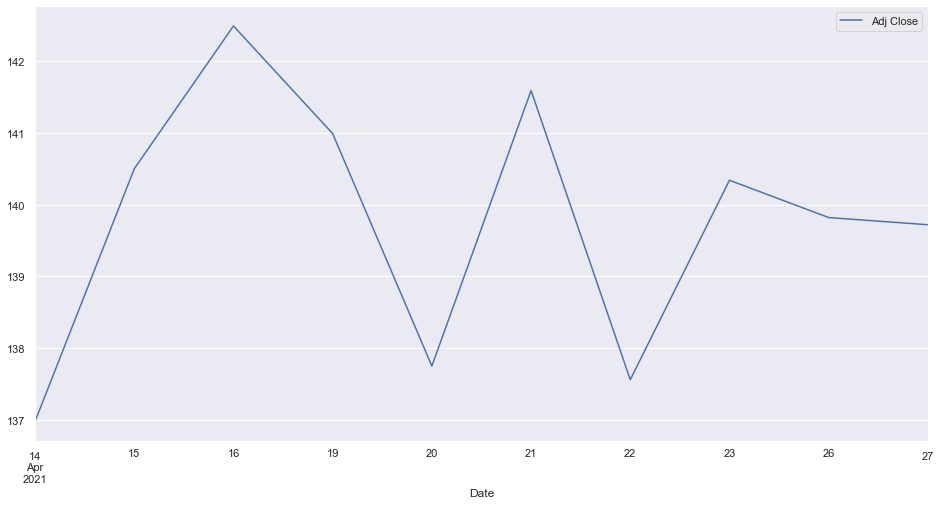

In [38]:
df_macd[['Adj Close']].tail(10).plot(figsize = (16, 8))

<AxesSubplot:xlabel='Date'>

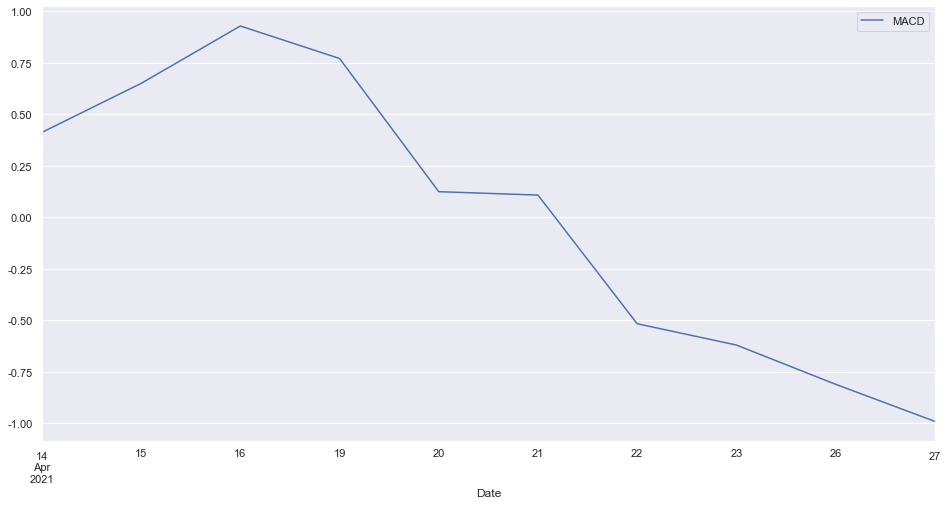

In [40]:
df_macd[['MACD']].tail(10).plot(figsize = (16, 8))